# Problem Statement
Cardiovascular diseases are among the top causes of mortality globally, making early detection vital for successful treatment and management. Traditional ECG analysis, which is largely manual and performed in medical facilities, can result in delayed recognition of heart irregularities. Such delays are particularly harmful in urgent situations where time is critical. This project seeks to fulfill the demand for an instantaneous, automated, and dependable system that provides patients with prompt feedback on their heart health, thereby potentially saving lives with early warnings.

![Heart ECG](https://www.hindustantimes.com/ht-img/img/2023/06/08/1600x900/heart_attack_ECG_1686237385933_1686237397168.jpg)

# Step-by-Step Guide for Anomaly Detection Using the ECG5000 Dataset

**Step 1: Define Anomalies**
> In the ECG5000 dataset, anomalies are typically defined as any class other than 'Normal'. We'll use the class label '1' to represent normal ECG patterns.

**Step 2: Experiment Setup**
> Data Preparation:
- Load and preprocess the dataset.
- Split the data into training and testing sets.
- Normalize the features.


**Step 3: Select Models for Comparison**
> We will use a mix of classical machine learning models and deep learning models:
> 1. Classical Machine Learning Models:
- Isolation Forest
- One-Class SVM
- Local Outlier Factor

> 2. Deep Learning Models:
- LSTM Autoencoders


# Import Essential Libraries

In [1]:
# Import necessary libraries for data frame manipulation and modelling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import copy
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Setting the matplotlib parameters
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8

# Setup random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setup the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# 1.0 Loading Dataset and EDA

## 1.1 ECG5000 Data Overview

The [ECG5000 dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) comprises 5,000 time series instances, each with 140 data points, representing individual heartbeats from patients diagnosed with congestive heart failure. An electrocardiogram (ECG) records the heart's electrical activity, which prompts muscle contractions and enables blood pumping. Each sequence in the dataset represents the electrical pattern of a heartbeat, providing insight into cardiac function. [[1]](https://www.heartandstroke.ca/heart/tests/electrocardiogram)


The ECG5000 dataset categorizes heartbeats into five distinct classes, each representing a different type of cardiac event:
1. `Normal (N):` This class represents the standard heartbeat in a healthy individual, with each cardiac cycle typically taking about 0.8 seconds, reflecting a heart rate of 70 to 75 beats per minute.
2. `R-on-T Premature Ventricular Contraction (R-on-T PVC):` This is a specific type of premature heartbeat where a ventricular contraction occurs prematurely and falls on the T wave of the preceding heartbeat. This can disrupt the normal rhythm of the heart.
3. `Premature Ventricular Contraction (PVC):` In this class, the ventricular contractions occur earlier than the next expected normal heartbeat, leading to a feeling of a skipped beat.
4. `Supra-ventricular Premature or Ectopic Beat (SP or EB):` These are premature heartbeats originating from the atria, just above the ventricles. They are less severe than ventricular contractions but can still indicate irregular cardiac activity.
5. `Unclassified Beat (UB):` This category includes heartbeats that do not clearly fit into the other four classifications, often due to insufficient data or anomalies in the ECG readings.

Each heartbeat, regardless of type, generally lasts between 0.6 to 1 second in humans, with a normal frequency range of 60 to 100 beats per minute. These characteristics are crucial for analyzing heart function and identifying potential cardiac issues in clinical settings.

The dataset can be accessed through my Google Drive.

In [3]:
import gdown

url = "https://drive.google.com/file/d/1B7EfgOd5JJ8ZycC6gA5-iqYS_xkuzRuG/view?usp=sharing"
file_id = url.split("/")[-2]
prefix = "https://drive.google.com/uc?export=download&id="

gdown.download(prefix + file_id)
print("Data downloaded!")

Downloading...
From: https://drive.google.com/uc?export=download&id=1B7EfgOd5JJ8ZycC6gA5-iqYS_xkuzRuG
To: /content/ECG5000.zip
100%|██████████| 10.6M/10.6M [00:00<00:00, 52.9MB/s]

Data downloaded!


In [4]:
!unzip ECG5000.zip
!rm -rf ECG5000.zip

Archive:  ECG5000.zip
  inflating: ECG5000.txt             
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        


The dataset is available in multiple formats, but we are particularly interested in the **ARFF** files, which we will load into Pandas DataFrames for analysis. We will combine the training and test data into a single data frame.

In [5]:
# Load the arff file with scipy
train_arff = arff.loadarff('ECG5000_TRAIN.arff')
test_arff = arff.loadarff('ECG5000_TEST.arff')

In [6]:
# Convert arff file into pandas dataframe
train_df = pd.DataFrame(train_arff[0])
test_df = pd.DataFrame(test_arff[0])

# Concatenate the dataframes
df = pd.concat([train_df, test_df], axis=0)

**Optional:** Read through CSV file that I prepared

In [ ]:
# df = pd.read_csv('ecg5000_concat.csv')

## 1.2 EDA

In [7]:
# Check the dataframe
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'


In [8]:
# Check the dimension of the dataframe
df.shape

(5000, 141)

In [9]:
# Check the columns of the dataframe
df.columns

Index(['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9',
       'att10',
       ...
       'att132', 'att133', 'att134', 'att135', 'att136', 'att137', 'att138',
       'att139', 'att140', 'target'],
      dtype='object', length=141)

In [10]:
# Check the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4499
Columns: 141 entries, att1 to target
dtypes: float64(140), object(1)
memory usage: 5.4+ MB


<font color='orange'>Note: </font> From our observations, the dataframe contains 5000 samples, where each row represents a single heartbeat record. The columns from index 0 to 139 correspond to the data points of the heartbeat, and the final column contains the label classifying the type of heartbeat.

In [11]:
# Check the unique values in the df['target']
df['target'].value_counts()

target
b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: count, dtype: int64

<font color='orange'>Note: </font>

The distribution of heartbeat classes in the dataset is summarized as follows:

- `Class 1 ("b'1'"):` Represents normal heartbeats and is the most common class with 2,919 samples.
- `Class 2 ("b'2'"):` Includes R-on-T Premature Ventricular Contractions (R on T) with 1,767 samples.
- `Class 4 ("b'4'"):` Pertains to Supra-ventricular Premature or Ectopic Beats (SP) with 194 samples.
- `Class 3 ("b'3'"):` Consists of Premature Ventricular Contractions (PVC) with 96 samples.
- `Class 5 ("b'5'"):` Contains Unclassified Beats (UB), being the rarest category with only 24 samples.

This distribution indicates that normal heartbeats and R-on-T PVCs are the most frequently observed classes in the dataset, whereas unclassified beats are relatively rare.

In [12]:
# Map the target column to facilitate the analysis
df['target'] = df['target'].map({b'1': 1, b'2': 2, b'3': 3, b'4': 4, b'5': 5})

In [13]:
# Check the unique values in the df['target']
df['target'].value_counts()

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64

In [14]:
# Specify the target labels
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

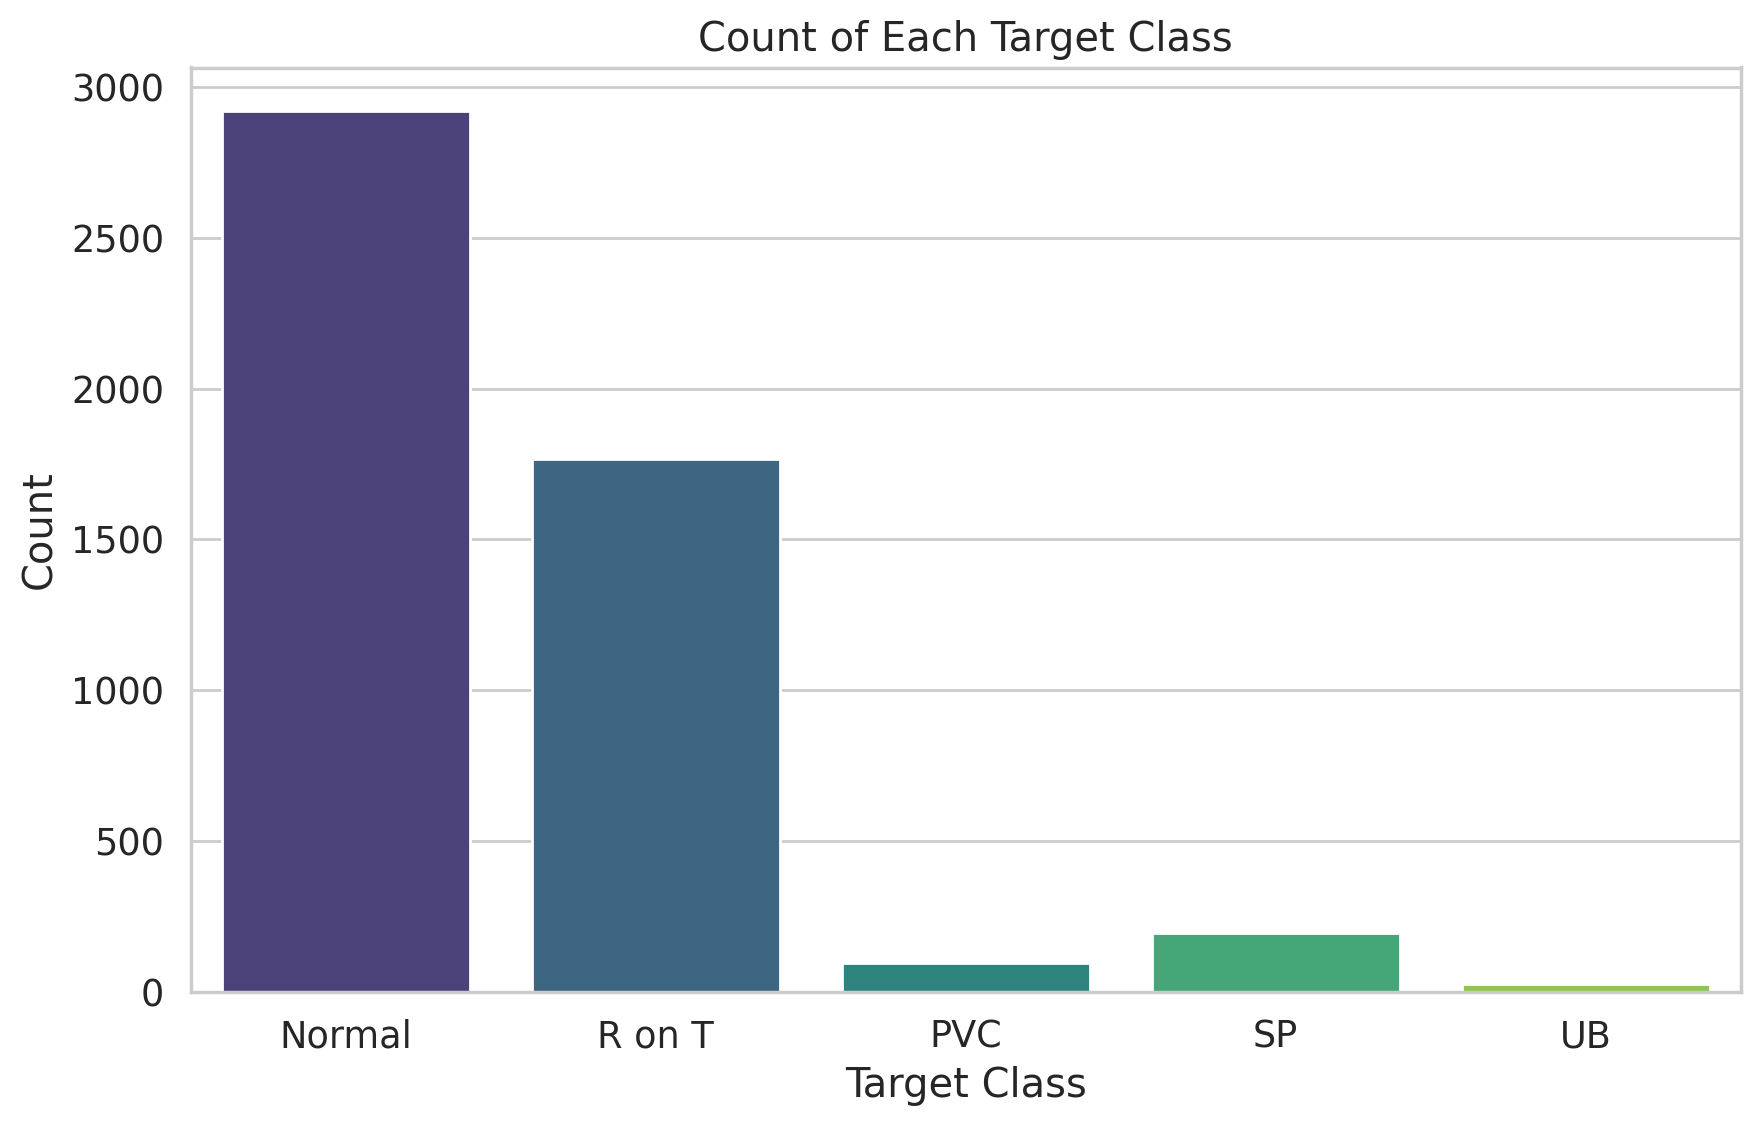

In [15]:
# Create a count plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df, order=range(1, 6), palette='viridis')

# Setting the tick labels for better readability
plt.xticks(ticks=range(5), labels=class_names)

# Adding labels and title for clarity
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Count of Each Target Class')

# Show the plot
plt.show()

In [16]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    """
    Plots a smoothed time series with a band representing the variability around the mean.

    Parameters:
        data (array-like): The input time series data.
        class_name (str): The title of the plot, typically the class or category of the data.
        ax (matplotlib.axes.Axes): The matplotlib Axes object on which the plot will be drawn.
        n_steps (int): The number of steps for rolling calculation. Defaults to 10.

    Returns:
        None: Modifies the ax object with the plotted data.
    """

    # Convert the input data to a pandas DataFrame for ease of manipulation
    time_series_df = pd.DataFrame(data)

    # Calculate the rolling mean and standard deviation
    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    # Calculate the upper and lower bounds of the confidence interval
    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    # Plot the smoothed time series and the confidence interval
    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125  # Light fill in the confidence interval
    )
    ax.set_title(class_name)  # Set the title of the plot

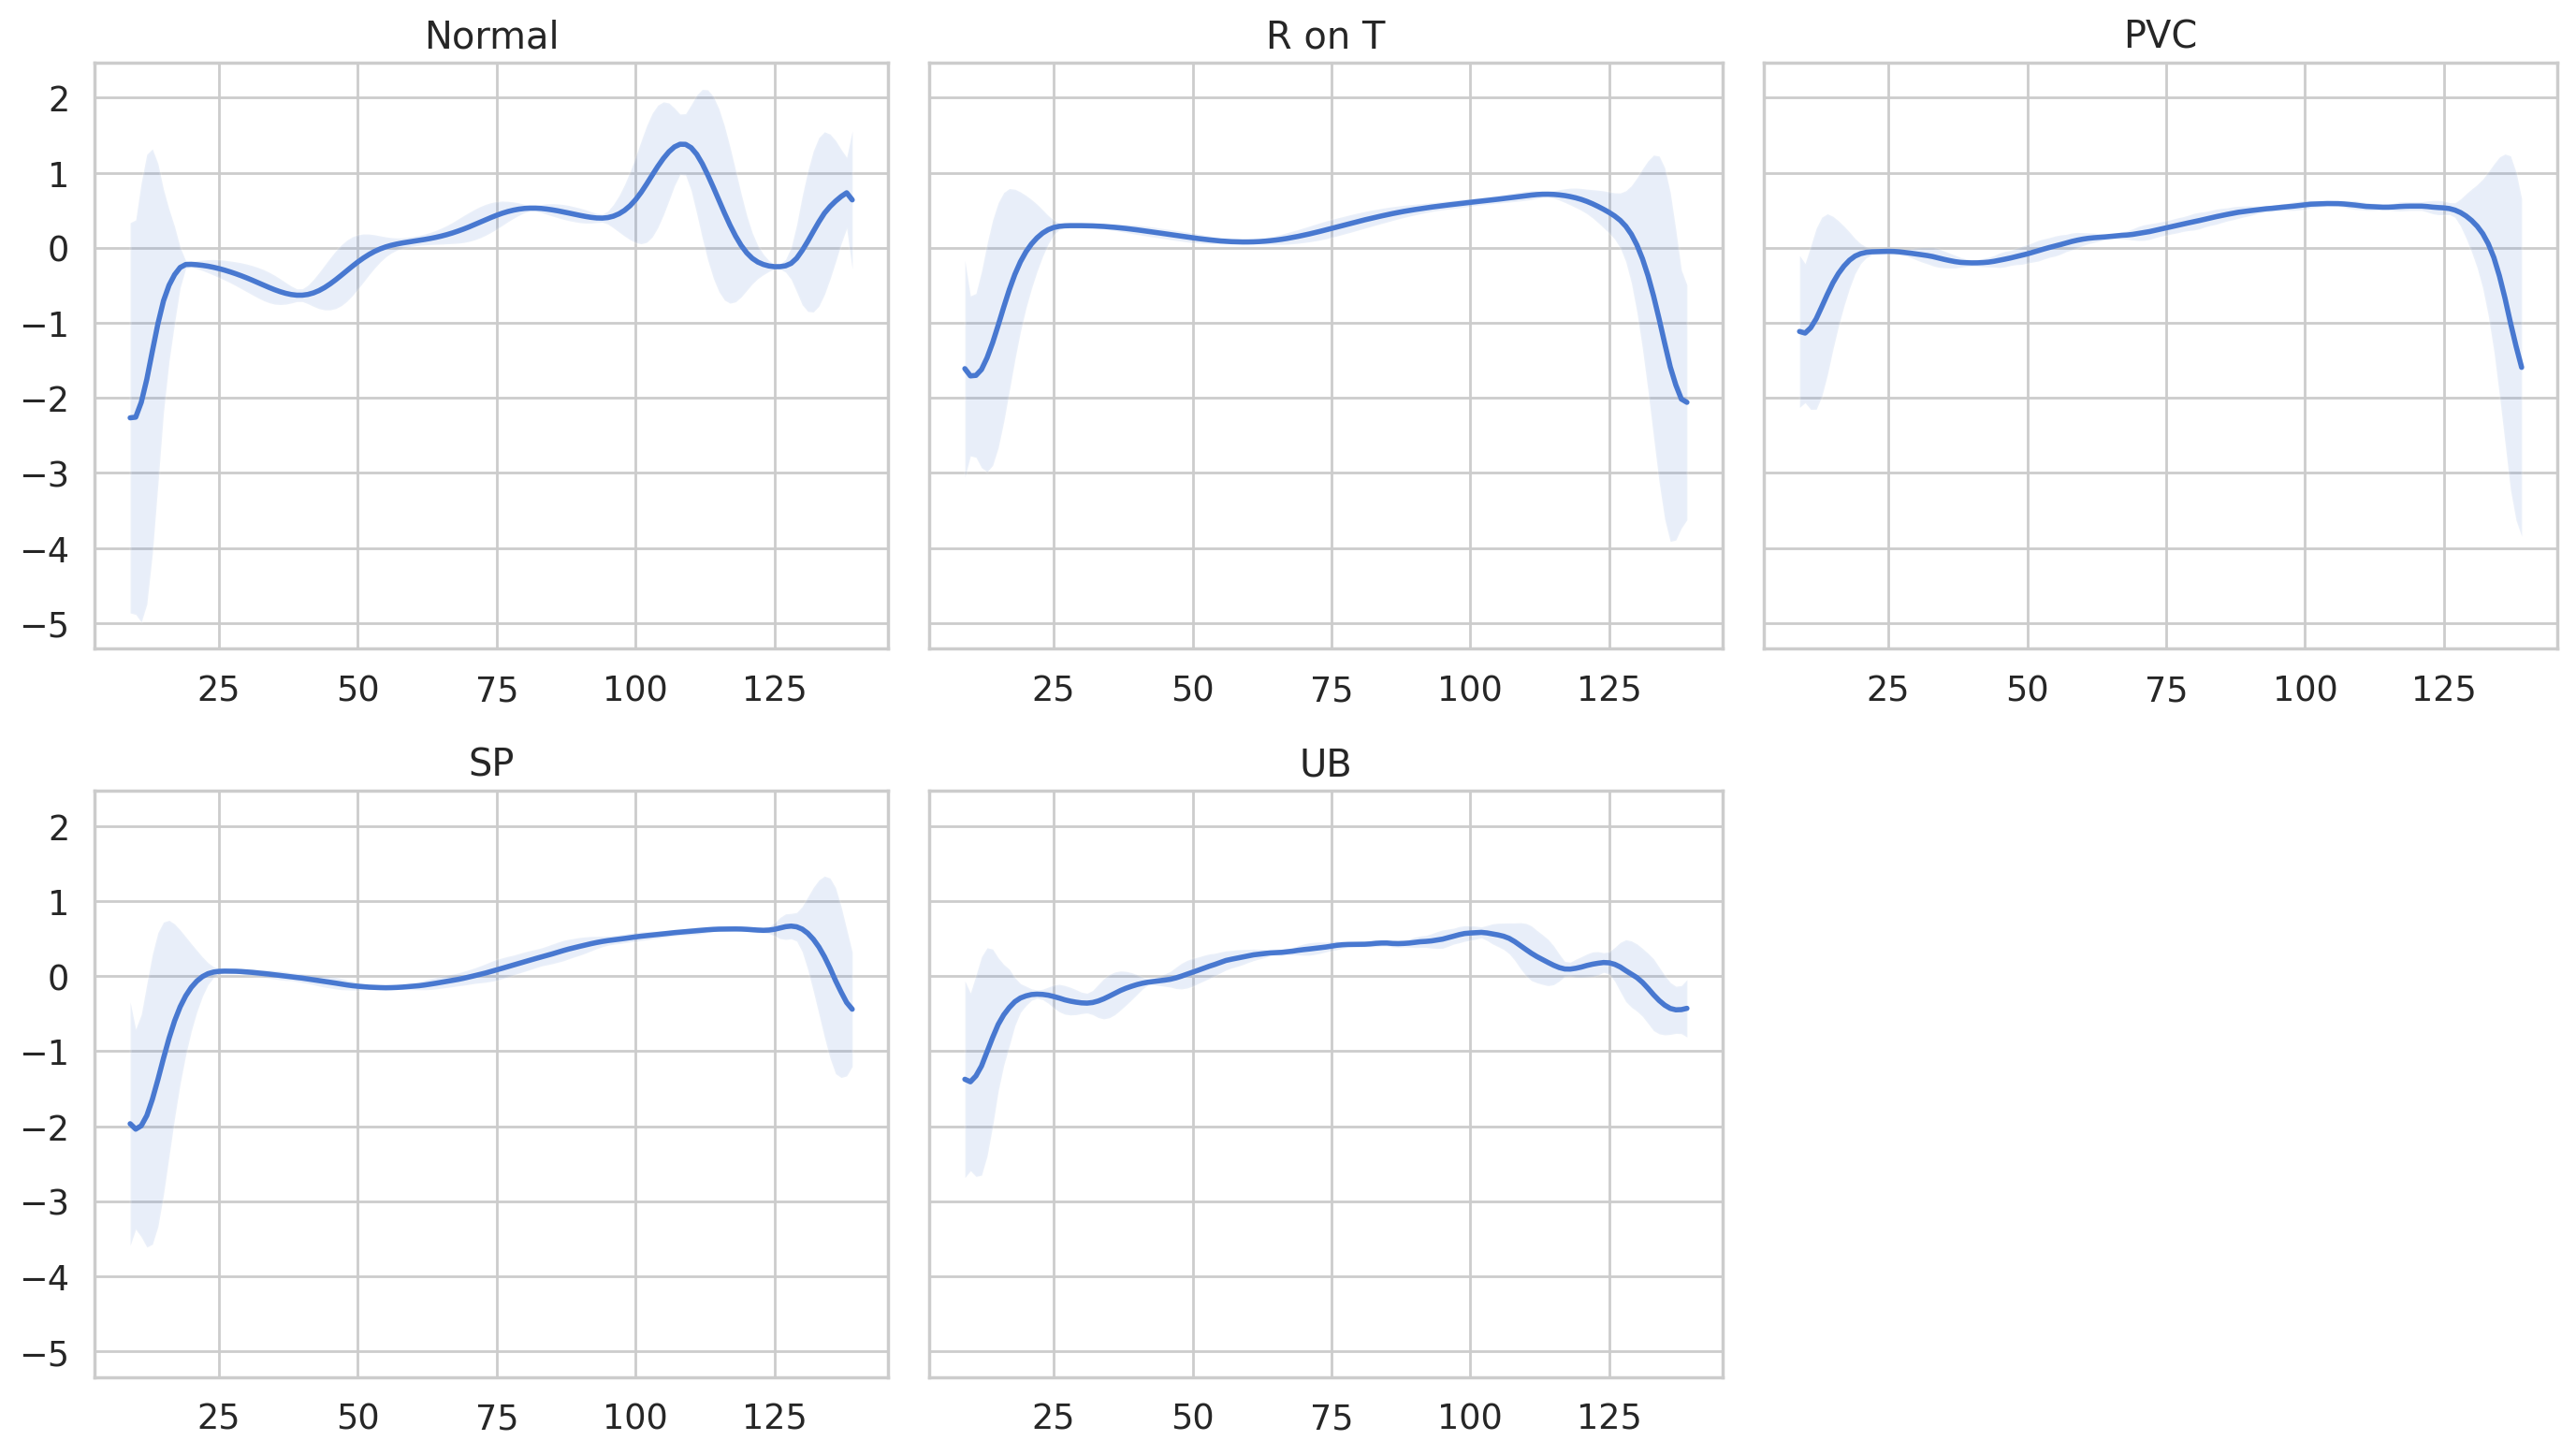

In [17]:
# Get unique classes from the dataframe
classes = df.target.unique()

# Set up a subplot grid with one row for every three classes, adding an extra row if needed
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

# Iterate through each class to plot its time series
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    # Extract data for the current class, compute the mean across samples, and convert to numpy array
    data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    # Plot the time series using the defined function
    plot_time_series_class(data, class_names[i], ax)

# If there are leftover axes in the last row, delete the last one
fig.delaxes(axs.flat[-1])
# Adjust layout for better fit and to handle overlap
fig.tight_layout()

<font color='orange'>Decision Making: </font>The class distribution analysis reveals a favorable scenario for our anomaly detection task. While normal heartbeats and R-on-T PVCs are the most frequent classes, unclassified beats (potential anomalies) are relatively rare. Additionally, the distinct pattern observed in the normal class compared to others suggests a good separability between normal and anomalous ECG segments. This characteristic can be leveraged by the `anomaly detection` models to effectively identify and classify infrequent and potentially abnormal heart rhythms within the ECG data.

# 2.0 Data Preprocessing

1. **Segregating Data into Normal and Anomalous Categories:**
- `normal_df` is generated by selecting only those data points from the ECG dataset that are labeled as normal in the target column. This subset does not include the 'target' column itself.
- `anomaly_df` is formed by selecting data points labeled as anomalous, meaning their target values do not indicate a normal reading.

2. **Data Splitting:** The dataset containing normal readings (`normal_df`) is divided into training and validation datasets using a train_test_split method. The training set comprises 85% of the data, while the remaining 15% goes to the validation set. The validation set is further split, where 33% of it is designated as the test dataset, using the same random seed to ensure reproducibility of the splits.

3. **Feature Normalization:** The StandardScaler is utilized to standardize the features by removing the mean and scaling to unit variance. This normalization is first fitted on the training dataset (train_df) and then applied to the training, validation, and both test datasets. Normalizing the data is crucial as it ensures that the model isn't biased or misled by the scale of any feature and each feature contributes equally to the analysis.

In [18]:
# Separate normal and anomaly data
normal_df = df[df.target == CLASS_NORMAL]
normal_df = normal_df.drop(labels='target', axis=1)

anomaly_df = df[df.target != CLASS_NORMAL]
anomaly_df = anomaly_df.drop(labels='target', axis=1)

In [19]:
# Split the data
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=RANDOM_SEED)

# Normalize the features
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)
val_df_scaled = scaler.transform(val_df)
test_normal_df_scaled = scaler.transform(test_df)
test_anomaly_df_scaled = scaler.transform(anomaly_df)

# 3.0 Classic Machine Learning

In [20]:
# Prepare combined test set
X_test_combined = np.vstack((test_normal_df_scaled, test_anomaly_df_scaled))
y_test_combined = np.hstack((np.zeros(len(test_normal_df_scaled)), np.ones(len(test_anomaly_df_scaled))))

## 3.1 Isolation Forest

Due to its linear time complexity and unsupervised nature, `Isolation Forest` efficiently handles large, high-dimensional ECG datasets for anomaly detection.

In [21]:
# Isolation Forest
iso_forest = IsolationForest(contamination='auto', random_state=42)
iso_forest.fit(train_df_scaled)
y_pred_iso = iso_forest.predict(X_test_combined)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]
print("Isolation Forest Classification Report:")
print(classification_report(y_test_combined, y_pred_iso))
print("AUC-ROC:", roc_auc_score(y_test_combined, y_pred_iso))

Isolation Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.92      0.81       145
         1.0       0.99      0.98      0.98      2081

    accuracy                           0.97      2226
   macro avg       0.86      0.95      0.90      2226
weighted avg       0.98      0.97      0.97      2226

AUC-ROC: 0.9466072345854945


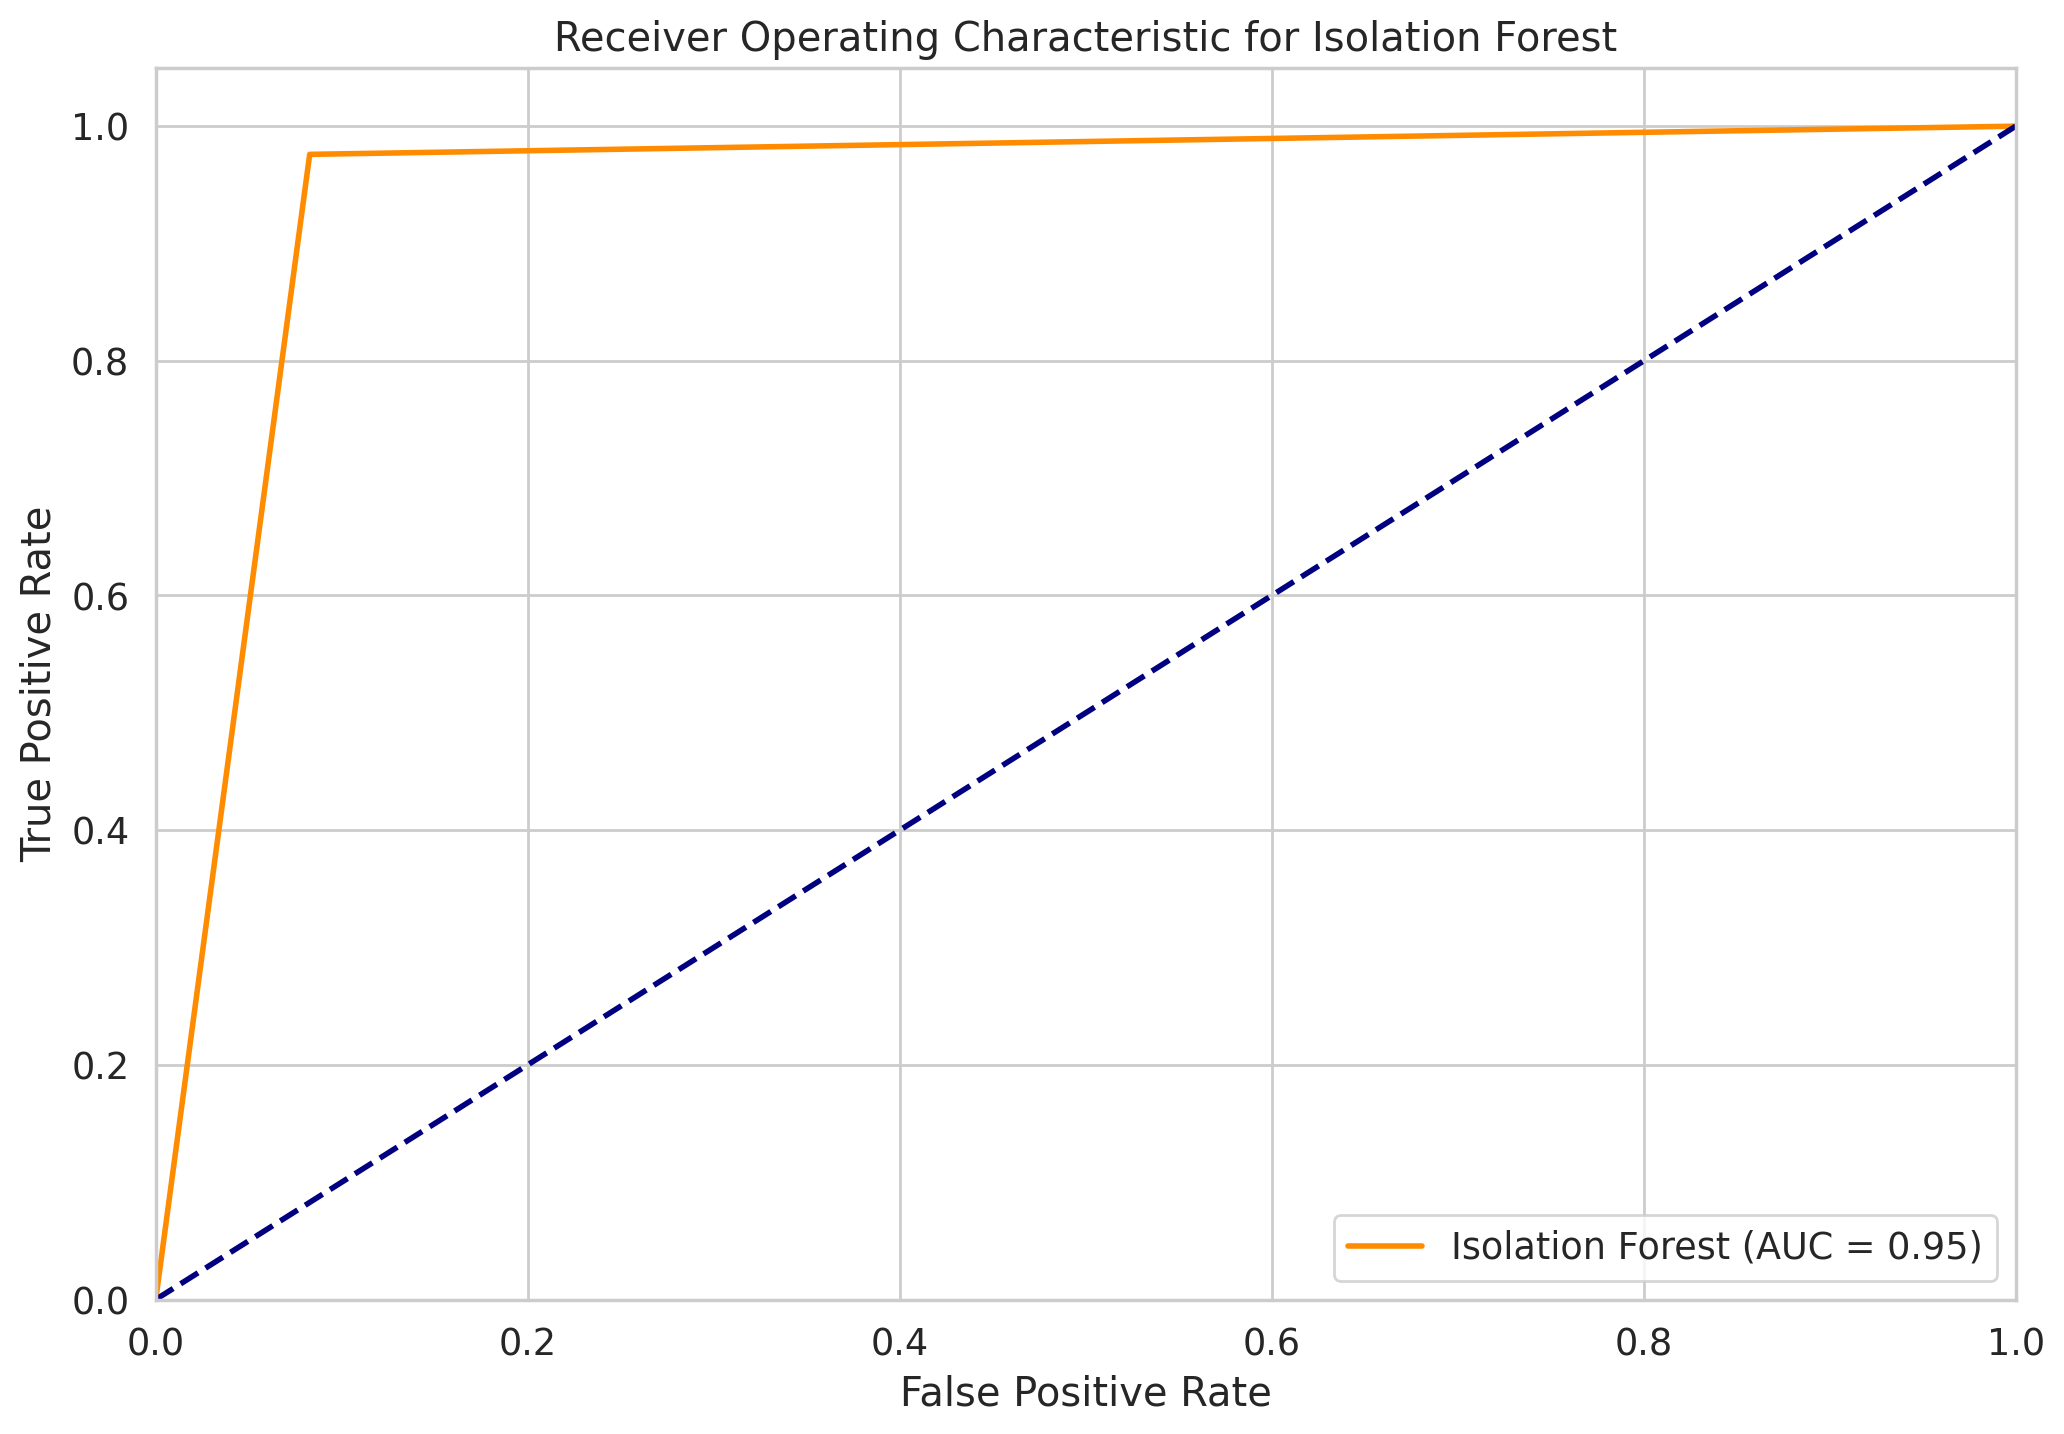

In [22]:
# Calculate ROC curve and AUC for Isolation Forest
fpr_iso, tpr_iso, _ = roc_curve(y_test_combined, y_pred_iso)
roc_auc_iso = auc(fpr_iso, tpr_iso)

# Plot ROC curve for Isolation Forest
plt.figure()
plt.plot(fpr_iso, tpr_iso, color='darkorange', lw=2, label='Isolation Forest (AUC = %0.2f)' % roc_auc_iso)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Isolation Forest')
plt.legend(loc="lower right")
plt.show()

## 3.2 One-Class SVM
`One-Class SVM` effectively learns the boundary of normal ECG patterns in high-dimensional spaces, enabling accurate anomaly detection with a strong theoretical foundation.

In [23]:
# One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='auto')
oc_svm.fit(train_df_scaled)
y_pred_svm = oc_svm.predict(X_test_combined)
y_pred_svm = [1 if x == -1 else 0 for x in y_pred_svm]
print("One-Class SVM Classification Report:")
print(classification_report(y_test_combined, y_pred_svm))
print("AUC-ROC:", roc_auc_score(y_test_combined, y_pred_svm))

One-Class SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.42      0.59       145
         1.0       0.96      1.00      0.98      2081

    accuracy                           0.96      2226
   macro avg       0.97      0.71      0.78      2226
weighted avg       0.96      0.96      0.95      2226

AUC-ROC: 0.7101045584848134


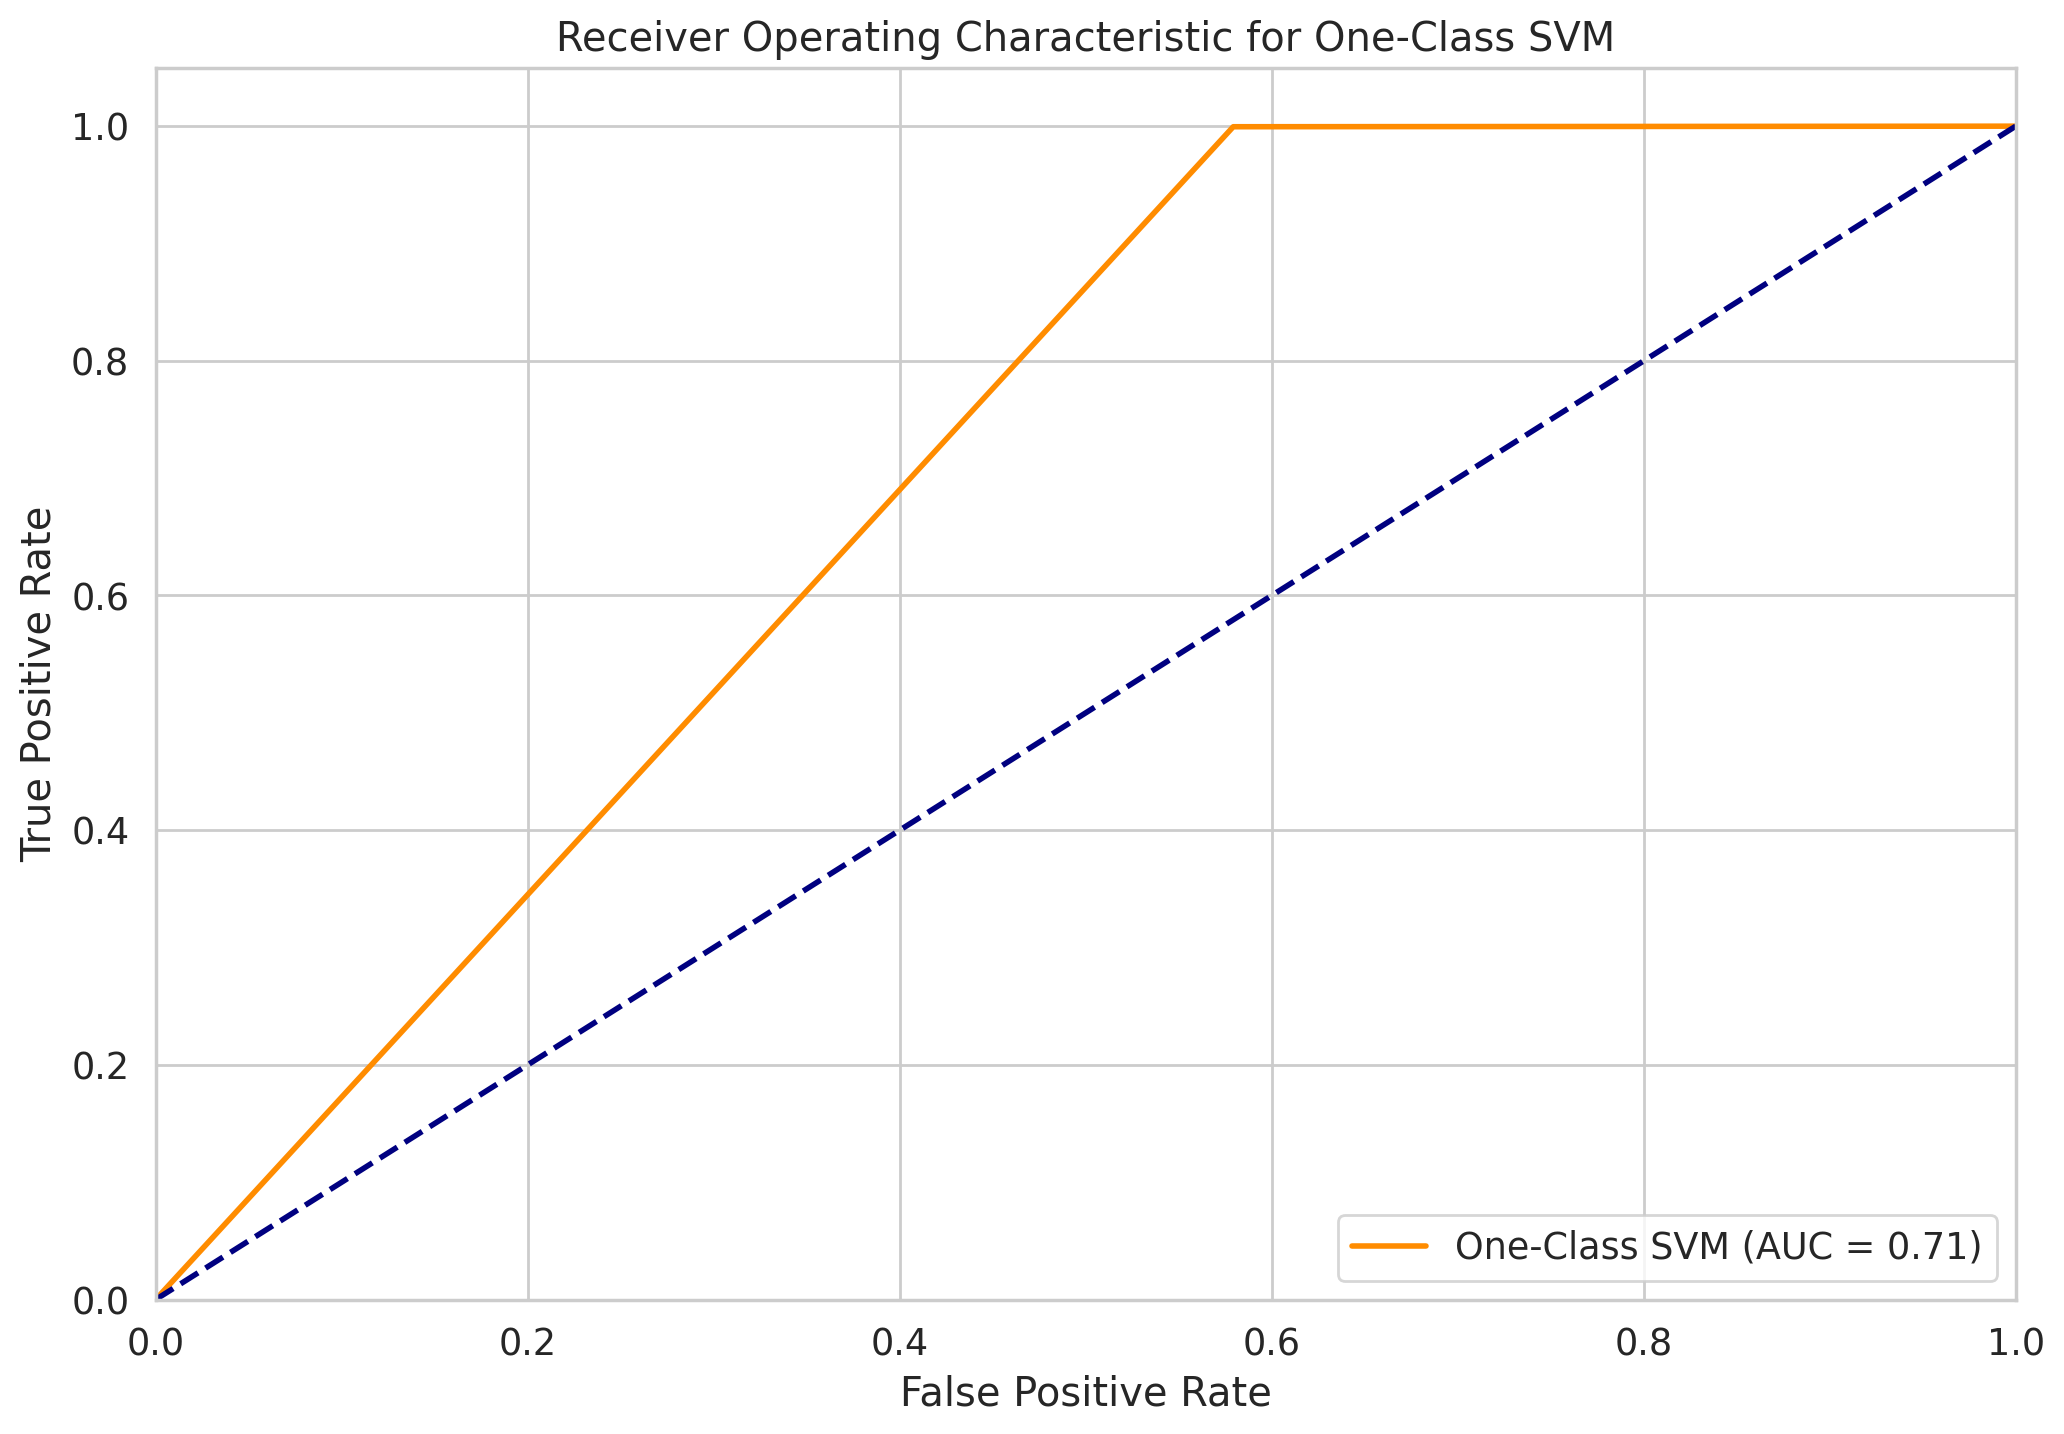

In [24]:
# Calculate ROC curve and AUC for One-Class SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test_combined, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve for One-Class SVM
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='One-Class SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for One-Class SVM')
plt.legend(loc="lower right")
plt.show()

## 3.3 Local Outlier Factor
`LOF` utilizes unsupervised local density analysis to identify subtle anomalies in ECG data by adapting to the data's local structure.

In [56]:
# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
lof.fit(train_df_scaled)
y_pred_lof = lof.fit_predict(X_test_combined)
y_pred_lof = [1 if x == -1 else 0 for x in y_pred_lof]
print("Local Outlier Factor Classification Report:")
print(classification_report(y_test_combined, y_pred_lof))
print("AUC-ROC:", roc_auc_score(y_test_combined, y_pred_lof))

Local Outlier Factor Classification Report:
              precision    recall  f1-score   support

         0.0       0.07      0.91      0.12       145
         1.0       0.93      0.09      0.16      2081

    accuracy                           0.14      2226
   macro avg       0.50      0.50      0.14      2226
weighted avg       0.88      0.14      0.16      2226

AUC-ROC: 0.4996221975509122


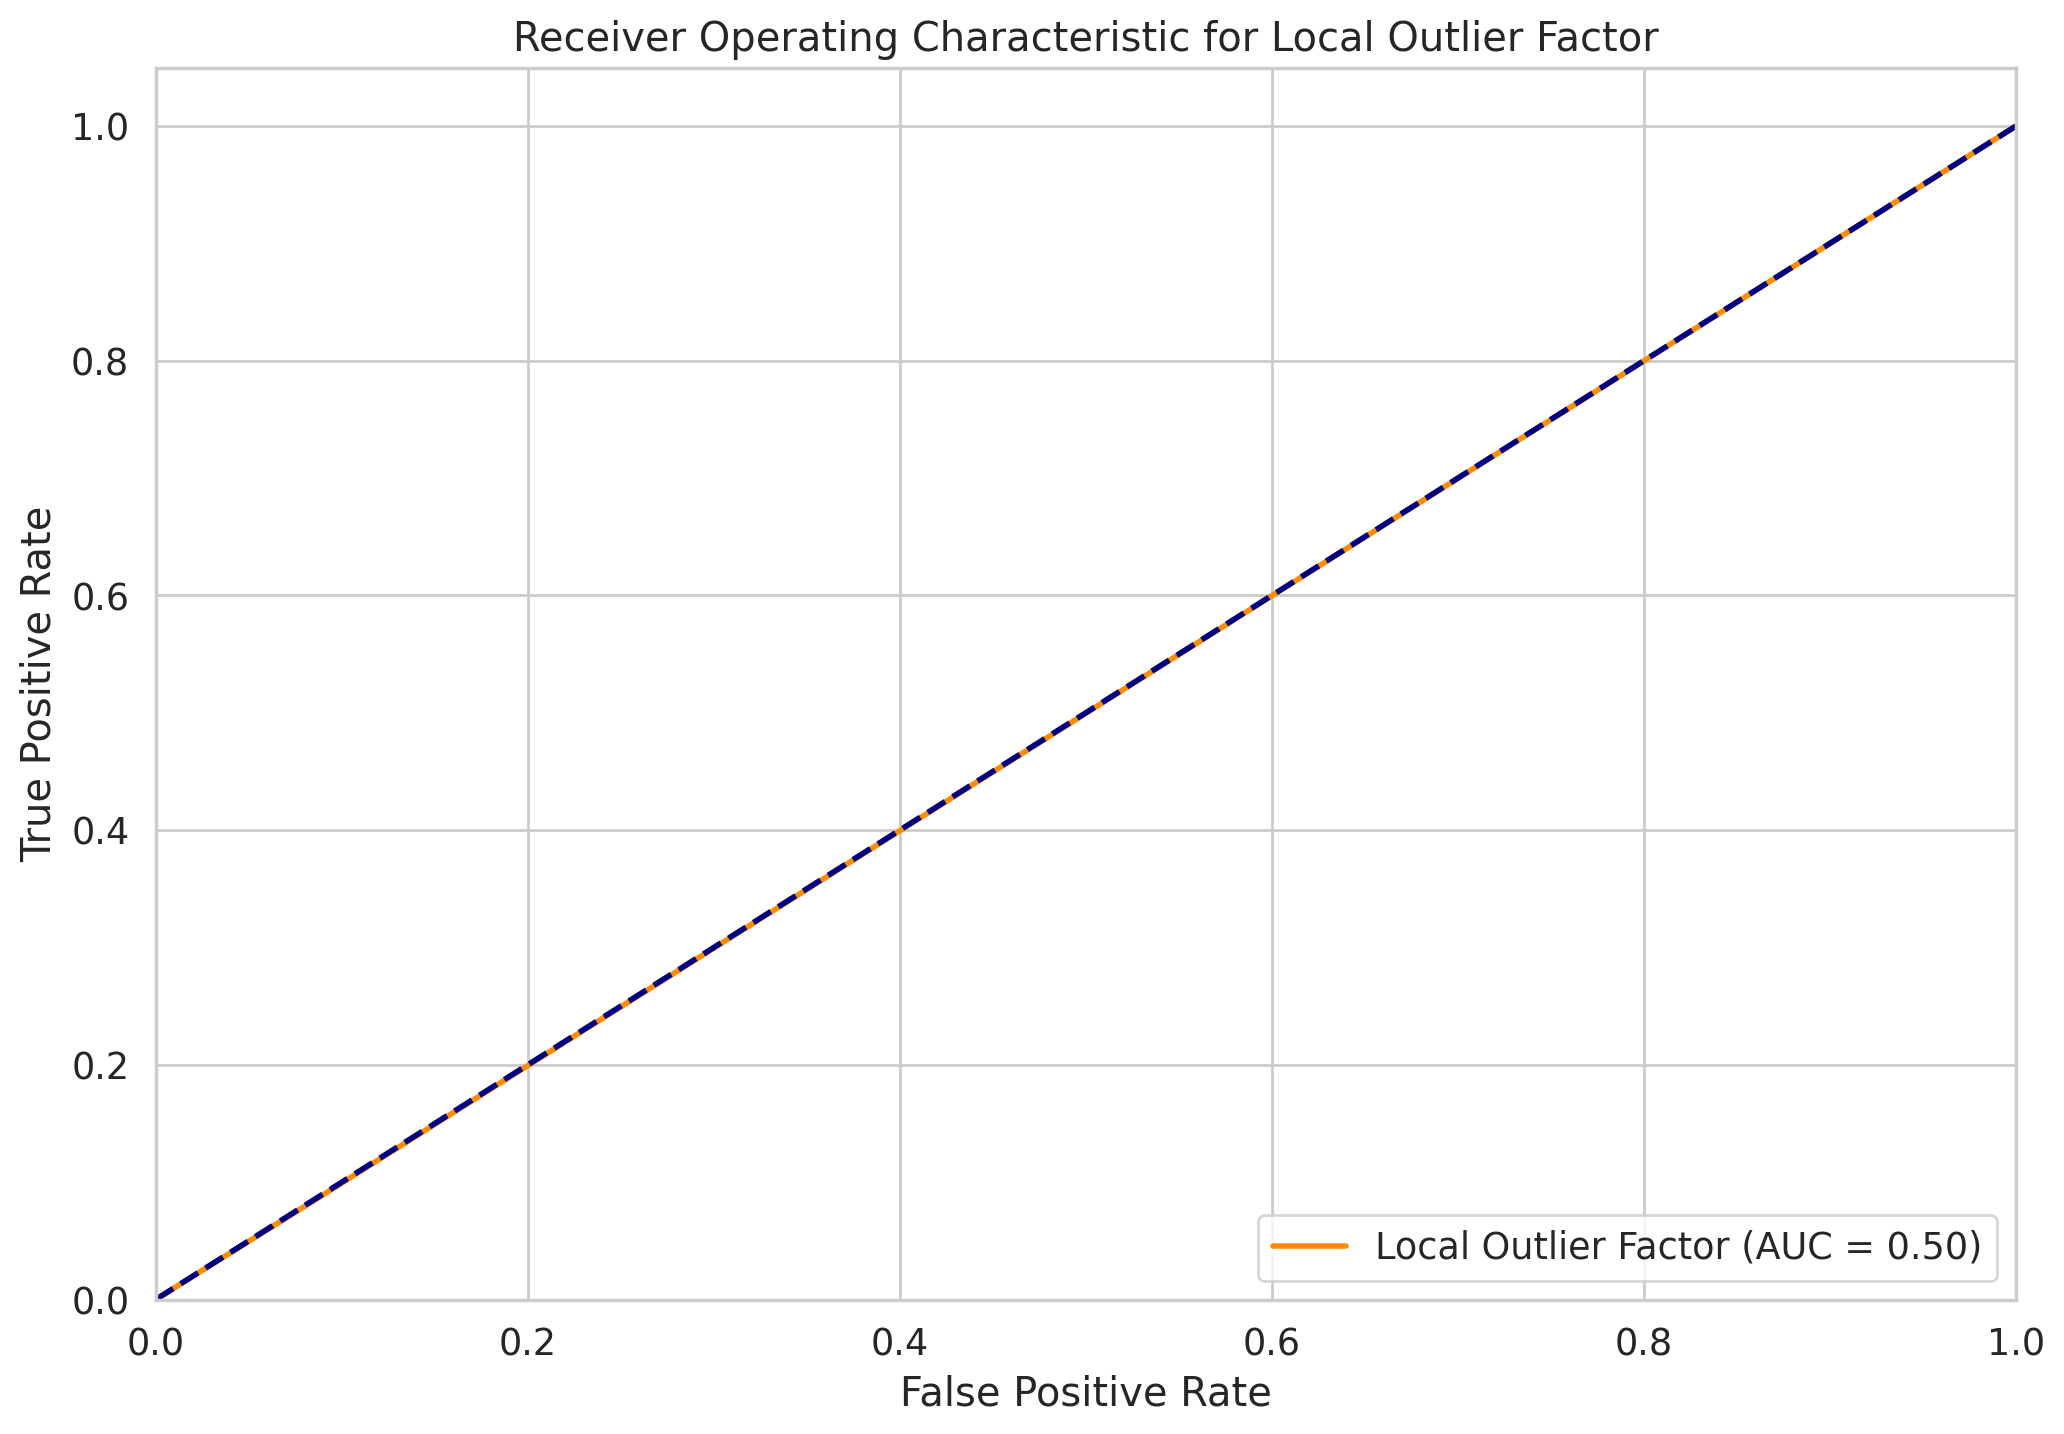

In [26]:
# Calculate ROC curve and AUC for Local Outlier Factor
fpr_lof, tpr_lof, _ = roc_curve(y_test_combined, y_pred_lof)
roc_auc_lof = auc(fpr_lof, tpr_lof)

# Plot ROC curve for Local Outlier Factor
plt.figure()
plt.plot(fpr_lof, tpr_lof, color='darkorange', lw=2, label='Local Outlier Factor (AUC = %0.2f)' % roc_auc_lof)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Local Outlier Factor')
plt.legend(loc="lower right")
plt.show()

# 4.0 LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.
In this scenario, we're exploring the application of Time Series data to an Autoencoder, utilizing a few LSTM layers (forming an LSTM Autoencoder) to grasp the temporal patterns in the data.

To determine whether a sequence is normal or anomalous, we will establish a threshold; sequences exceeding this threshold will be classified as abnormal.

**Reconstruction Loss:**

The main goal in training an Autoencoder is to replicate the input as accurately as possible, which is achieved by minimizing a loss function similar to those used in supervised learning. This metric is referred to as reconstruction loss, with Cross-entropy loss and Mean squared error being typical examples.



![Autoencoder](https://www.researchgate.net/publication/336594630/figure/fig2/AS:814792885420033@1571273170513/LSTM-Autoencoder-for-Anomaly-Detection.png)


* LSTM Autoencoder Architecture [[2]](https://www.researchgate.net/figure/LSTM-Autoencoder-for-Anomaly-Detection_fig2_336594630)

## 4.1 Data Preprocessing

- **Function to Create PyTorch Dataset:** The `create_dataset` function is designed to transform a DataFrame into a format that is compatible with PyTorch modeling. It achieves this by converting the DataFrame into a list of sequences (where each sequence is a list of floating-point numbers), then transforming these sequences into PyTorch tensors, and finally determining the dimensions of the dataset in terms of sequence length and the number of features.

- **Dataset Creation for Various Sets:** The `create_dataset` function is used to generate separate datasets for the training, validation, normal testing, and anomalous testing phases. It also ensures that the sequence length and number of features identified in the training dataset are consistently applied across the model architecture. This systematic approach helps in maintaining uniformity across different sets for effective model training and evaluation.

In [27]:
# Function to create dataset for PyTorch
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [28]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

## 4.2 LSTM-based Autoencoder Implementation

This section details the implementation of an LSTM-based Autoencoder neural network using PyTorch, tailored for identifying anomalies in ECG data. The Autoencoder consists of two main components: the `Encoder` and the `Decoder`, each built as a subclass of `nn.Module`.

1. **Encoder Class**
>- **Purpose:** Compresses the input ECG sequence into a more compact, lower-dimensional form.
>- **Architecture:** Features two LSTM layers, where the initial layer processes the original ECG features and feeds its output to the second LSTM layer, which further condenses the data to a specified embedding dimension.
>- **Parameters:** Takes sequence length, number of features, and an optional embedding dimension (with a default of 64).

2. **Decoder Class**
>- **Purpose:** Reconstructs the ECG sequence from its encoded form.
>- **Architecture:** Designed to reflect the Encoder, it includes two LSTM layers and an additional linear layer that produces the final reconstructed ECG sequence.
>- **Parameters:** Receives the sequence length, input dimension (equivalent to the Encoder's embedding dimension), and the number of features.

3. **Recurrent Autoencoder Class**
>- **Integration of Encoder and Decoder:** Integrates both the Encoder and Decoder into a unified model framework. It initializes each component based on the provided sequence length, number of features, and embedding dimension.
>- **Forward Method:** Chronicles the complete data flow within the Autoencoder, from encoding the input to decoding it, culminating in the reconstructed output.

In [29]:
# Autoencoder Model
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(input_size=n_features, hidden_size=self.hidden_dim, num_layers=1, batch_first=True)
        self.rnn2 = nn.LSTM(input_size=self.hidden_dim, hidden_size=embedding_dim, num_layers=1, batch_first=True)

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(input_size=input_dim, hidden_size=input_dim, num_layers=1, batch_first=True)
        self.rnn2 = nn.LSTM(input_size=input_dim, hidden_size=self.hidden_dim, num_layers=1, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [30]:
# Initialize the Recurrent Autoencoder model
autoencoder_model = RecurrentAutoencoder(seq_len, n_features, 128).to(device)

## 4.3 Model Training

**Training Function for the Autoencoder Model:**

The `train_autoencoder` function is tasked with training the Autoencoder using both the training and validation datasets across a designated number of epochs. The model employs the `Adam` optimizer and utilizes the `L1 loss function` to evaluate the difference between the original and reconstructed sequences. Whenever a reduction in validation loss is detected, suggesting enhanced model performance, the function saves the model weights. Additionally, it records the history of both training and validation losses to facilitate further analysis.

In [31]:
# Define the train_autoencoder function
def train_autoencoder(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_loss = []
        for seq_true in train_dataset:
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        val_loss = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_loss.append(loss.item())

        train_loss = np.mean(train_loss)
        val_loss = np.mean(val_loss)
        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

<font color='orange'>Note: </font>LSTM Autoencoder takes one hour for the training, you can directly access the trained model.

In [32]:
# Train the Autoencoder model
autoencoder_model, history = train_autoencoder(autoencoder_model, train_dataset, val_dataset, n_epochs=150)

Epoch 1: train loss 58.97393419357232 val loss 51.75328424603459
Epoch 2: train loss 51.58887605309631 val loss 52.01257273442916
Epoch 3: train loss 53.34952516567318 val loss 52.16254257097993
Epoch 4: train loss 49.30017862623615 val loss 43.174387941588314
Epoch 5: train loss 45.80888405445842 val loss 40.55347882033208
Epoch 6: train loss 31.921921728888332 val loss 31.68204774303241
Epoch 7: train loss 29.07512570426907 val loss 28.994797446215113
Epoch 8: train loss 27.381854022332423 val loss 25.550684160746812
Epoch 9: train loss 26.184585461737598 val loss 29.644615170084982
Epoch 10: train loss 25.650621929653035 val loss 26.14845119320085
Epoch 11: train loss 26.96161469679021 val loss 25.595141319691525
Epoch 12: train loss 24.120974000256563 val loss 22.306379253140083
Epoch 13: train loss 23.76802397254781 val loss 21.19006095404511
Epoch 14: train loss 23.13237933851163 val loss 21.089908049781982
Epoch 15: train loss 22.959774094596597 val loss 20.778712223821127
Epoch

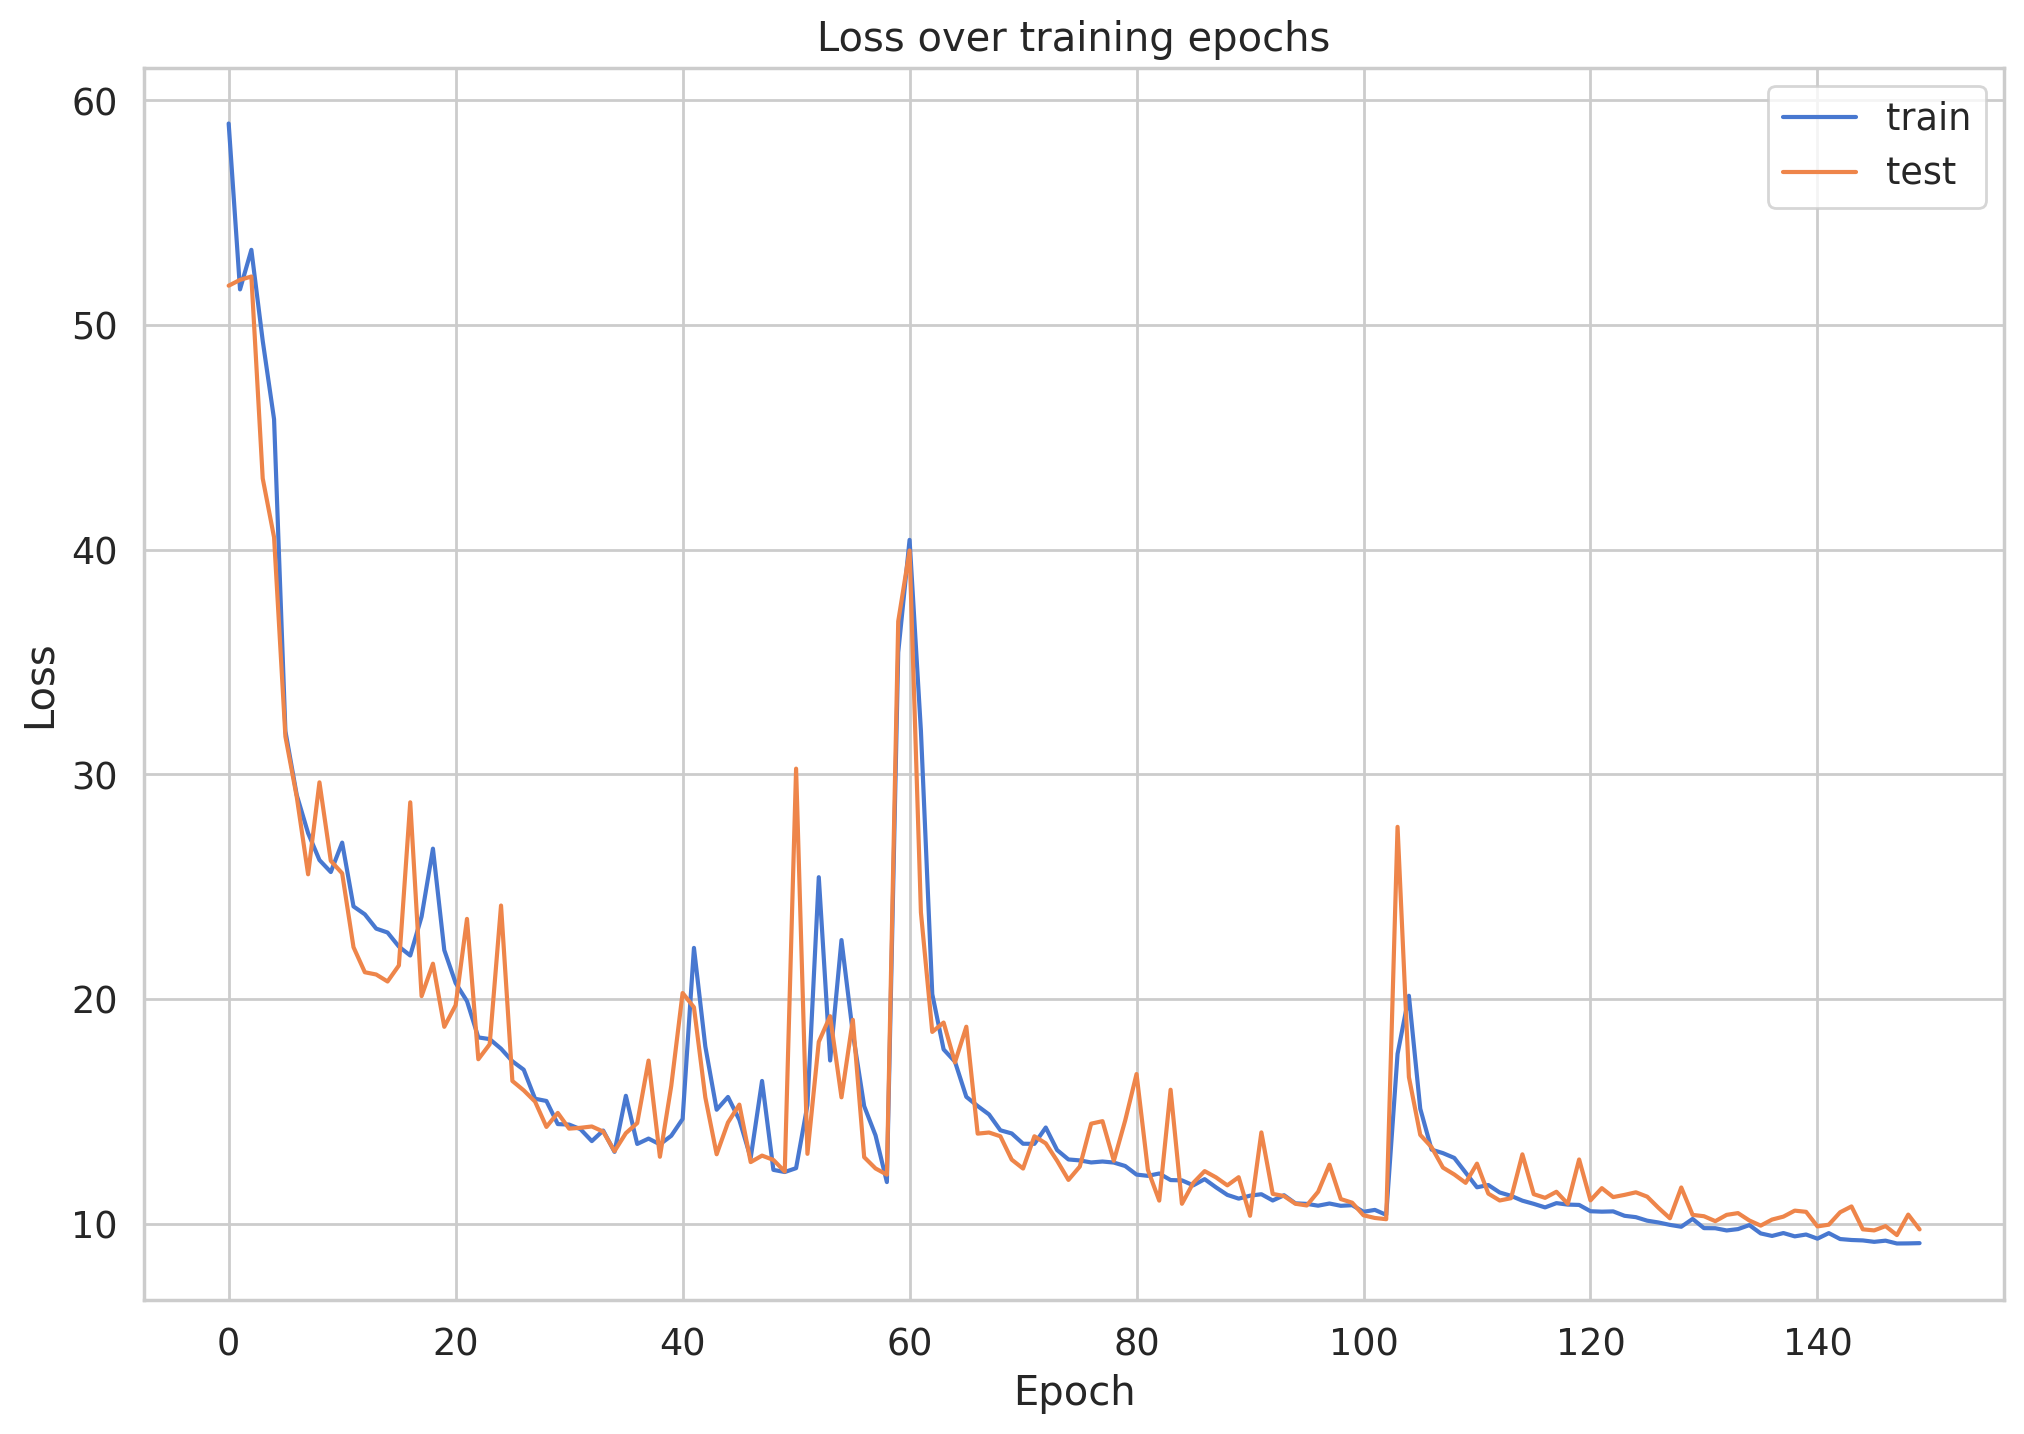

In [33]:
# Ploting losses over training epochs
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

In [34]:
# Save the model for backup and future testing
MODEL_PATH = 'autoencoder_model.pth'
torch.save(autoencoder_model, MODEL_PATH)

In [90]:
# To load immediately usage
# autoencoder_model = torch.load('autoencoder_model.pth')
# autoencoder_model = autoencoder_model.to(device)

## 4.4 Model Prediction
The `predict_autoencoder` is a function designed to process a dataset through the model, computing the reconstruction loss for each sequence. It outputs both the reconstructed sequences and their corresponding losses, which are crucial metrics for evaluating the model's performance.

In [91]:
# Define the predict function
def predict_autoencoder(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

<Axes: ylabel='Density'>

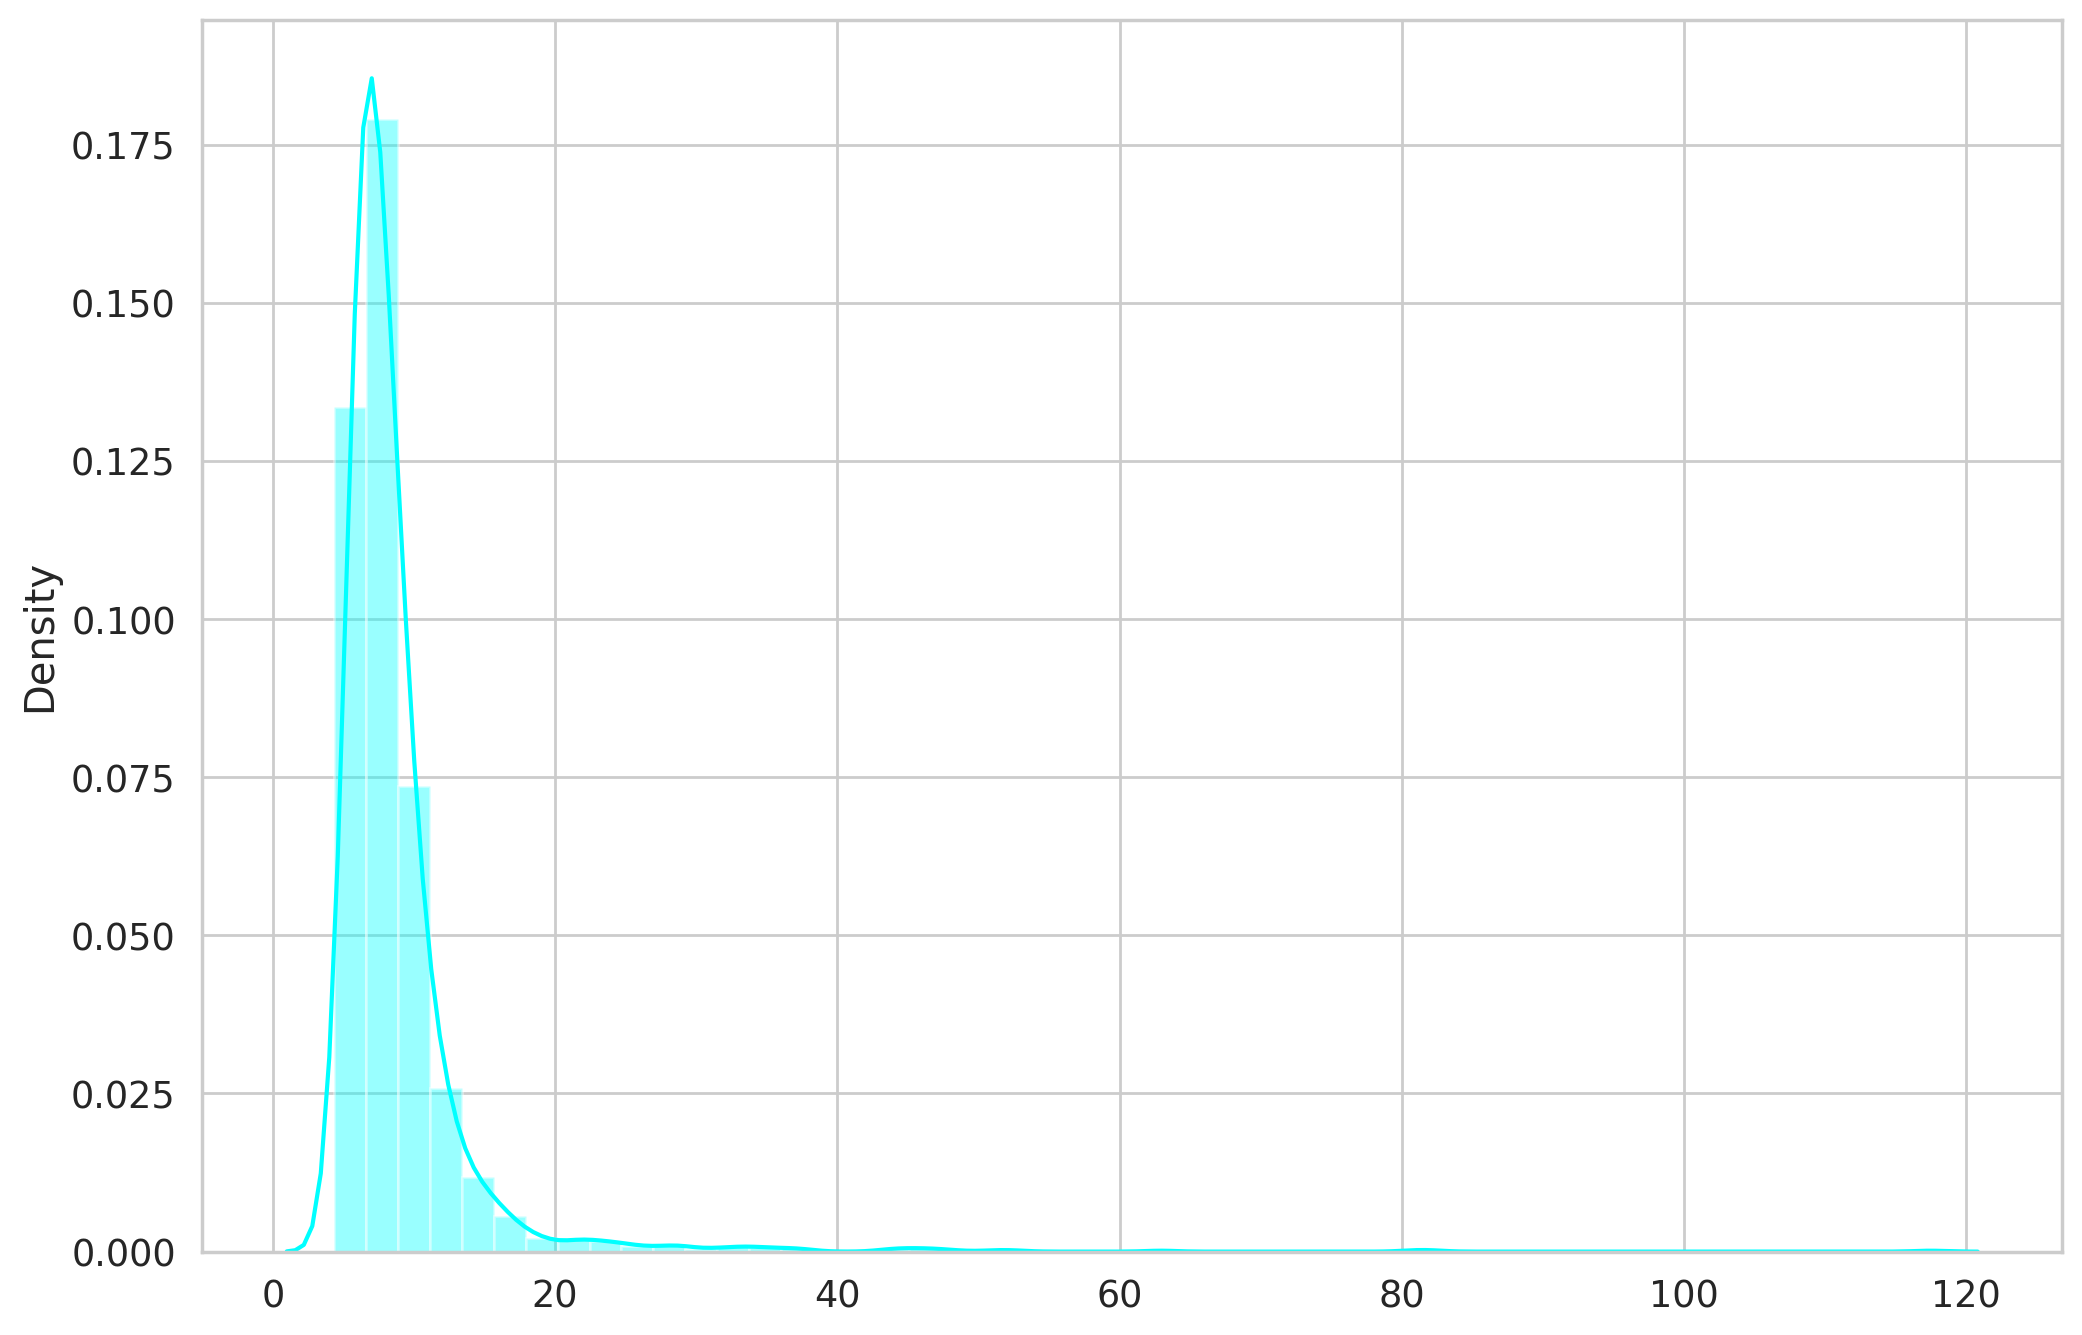

In [92]:
_, losses = predict_autoencoder(autoencoder_model, train_dataset)
sns.distplot(losses, bins=50, kde=True, label='Train',color='cyan')


<font color='green'>Normal Case Predictions</font>

<Axes: ylabel='Density'>

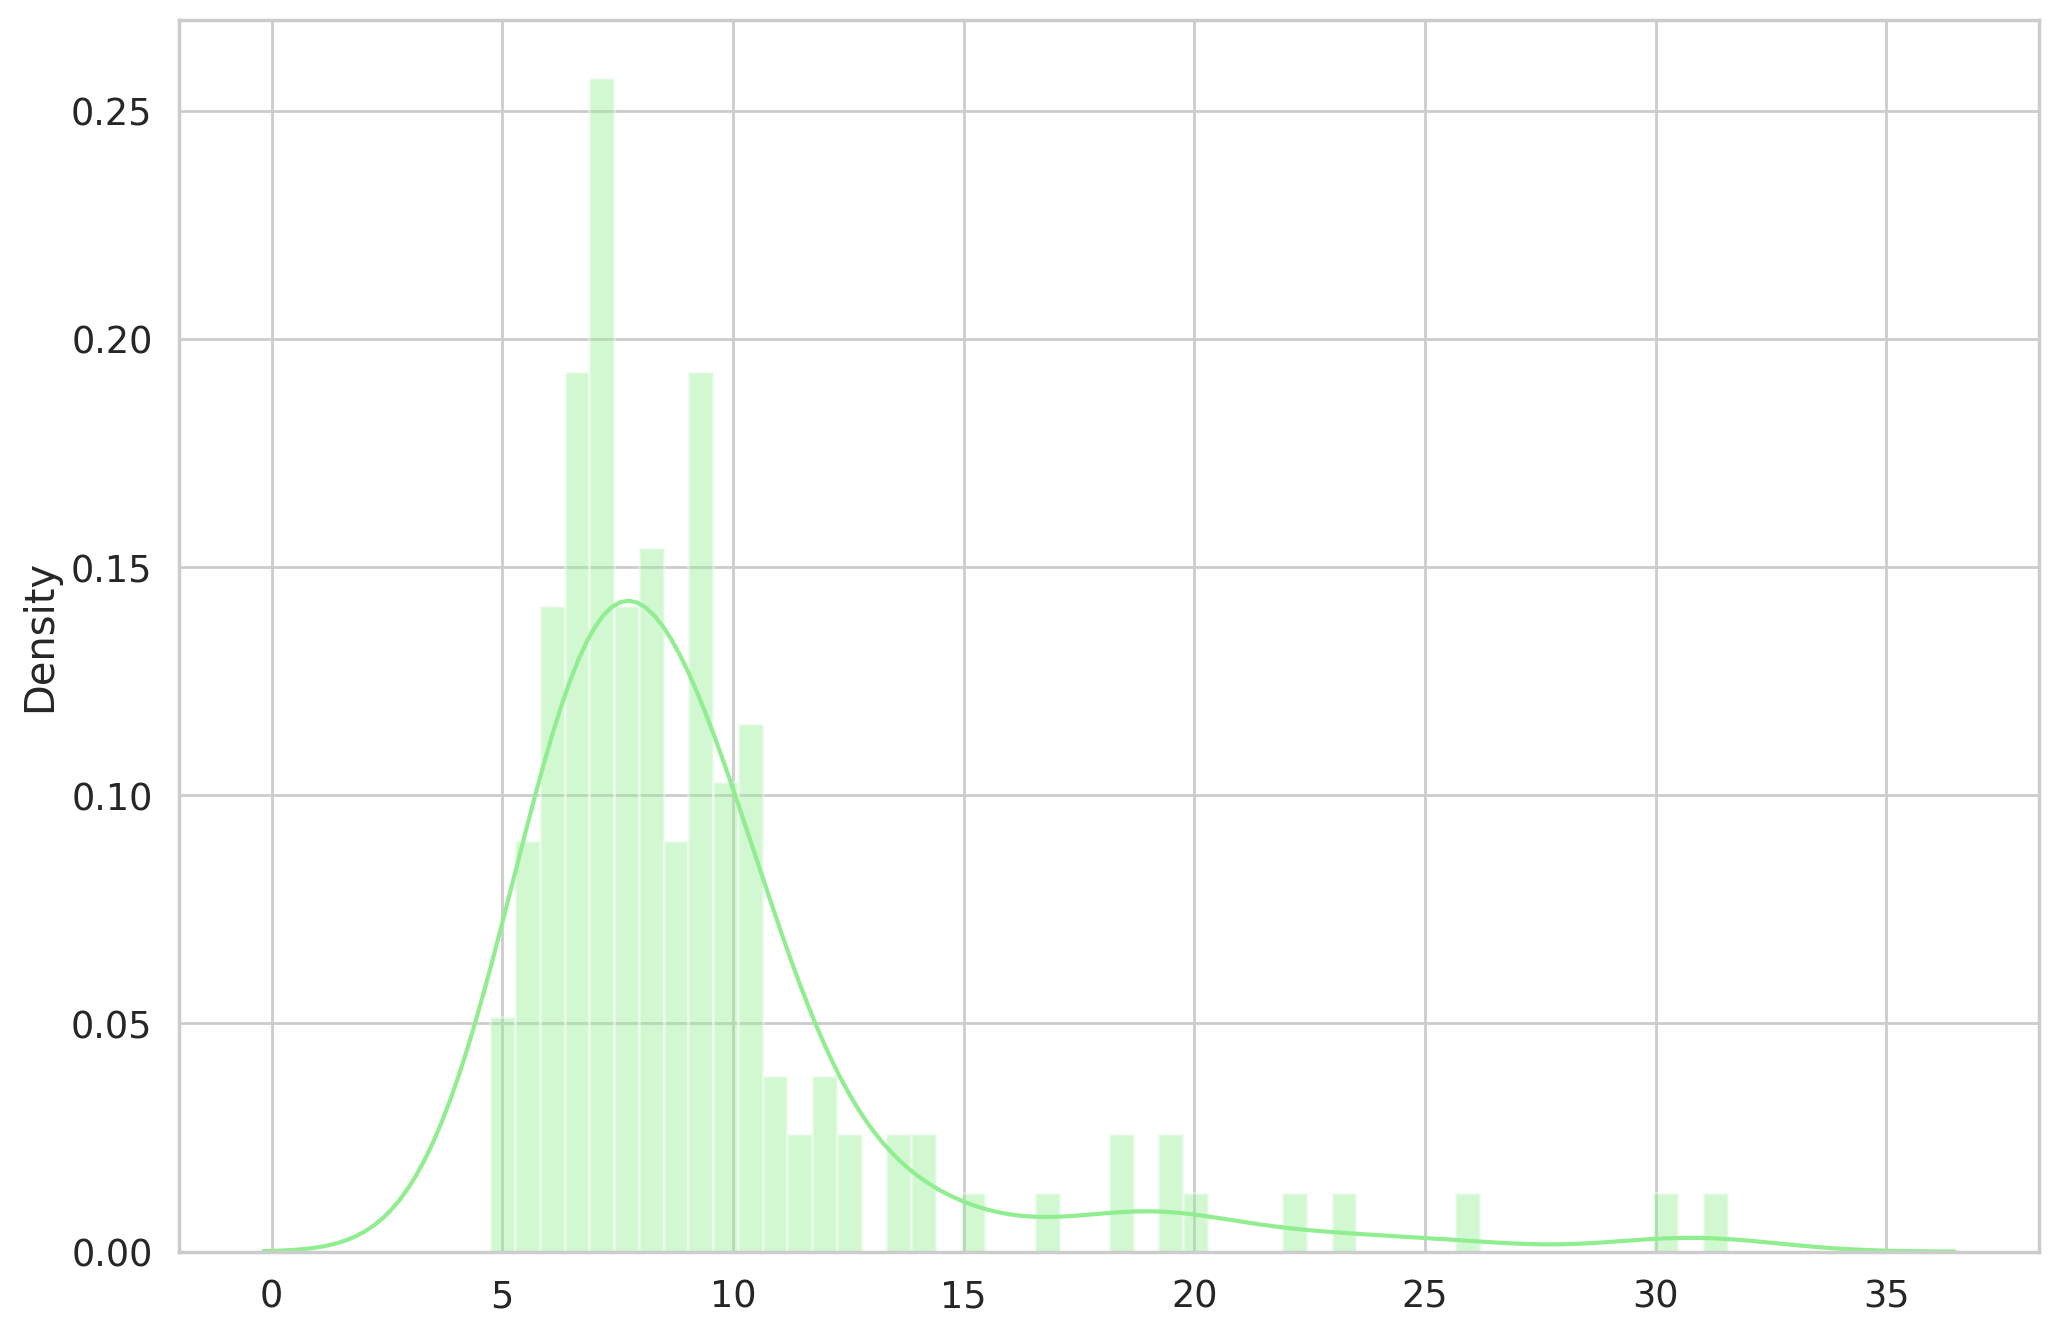

In [104]:
predictions, pred_losses = predict_autoencoder(autoencoder_model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True,color='lightgreen')

In [107]:
correct = sum(l <= 20 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 139/145


<font color='lightpink'>Anomaly Case Predictions</font>

In [108]:
anomaly_sample = test_anomaly_dataset[:len(test_normal_dataset)]

<Axes: ylabel='Density'>

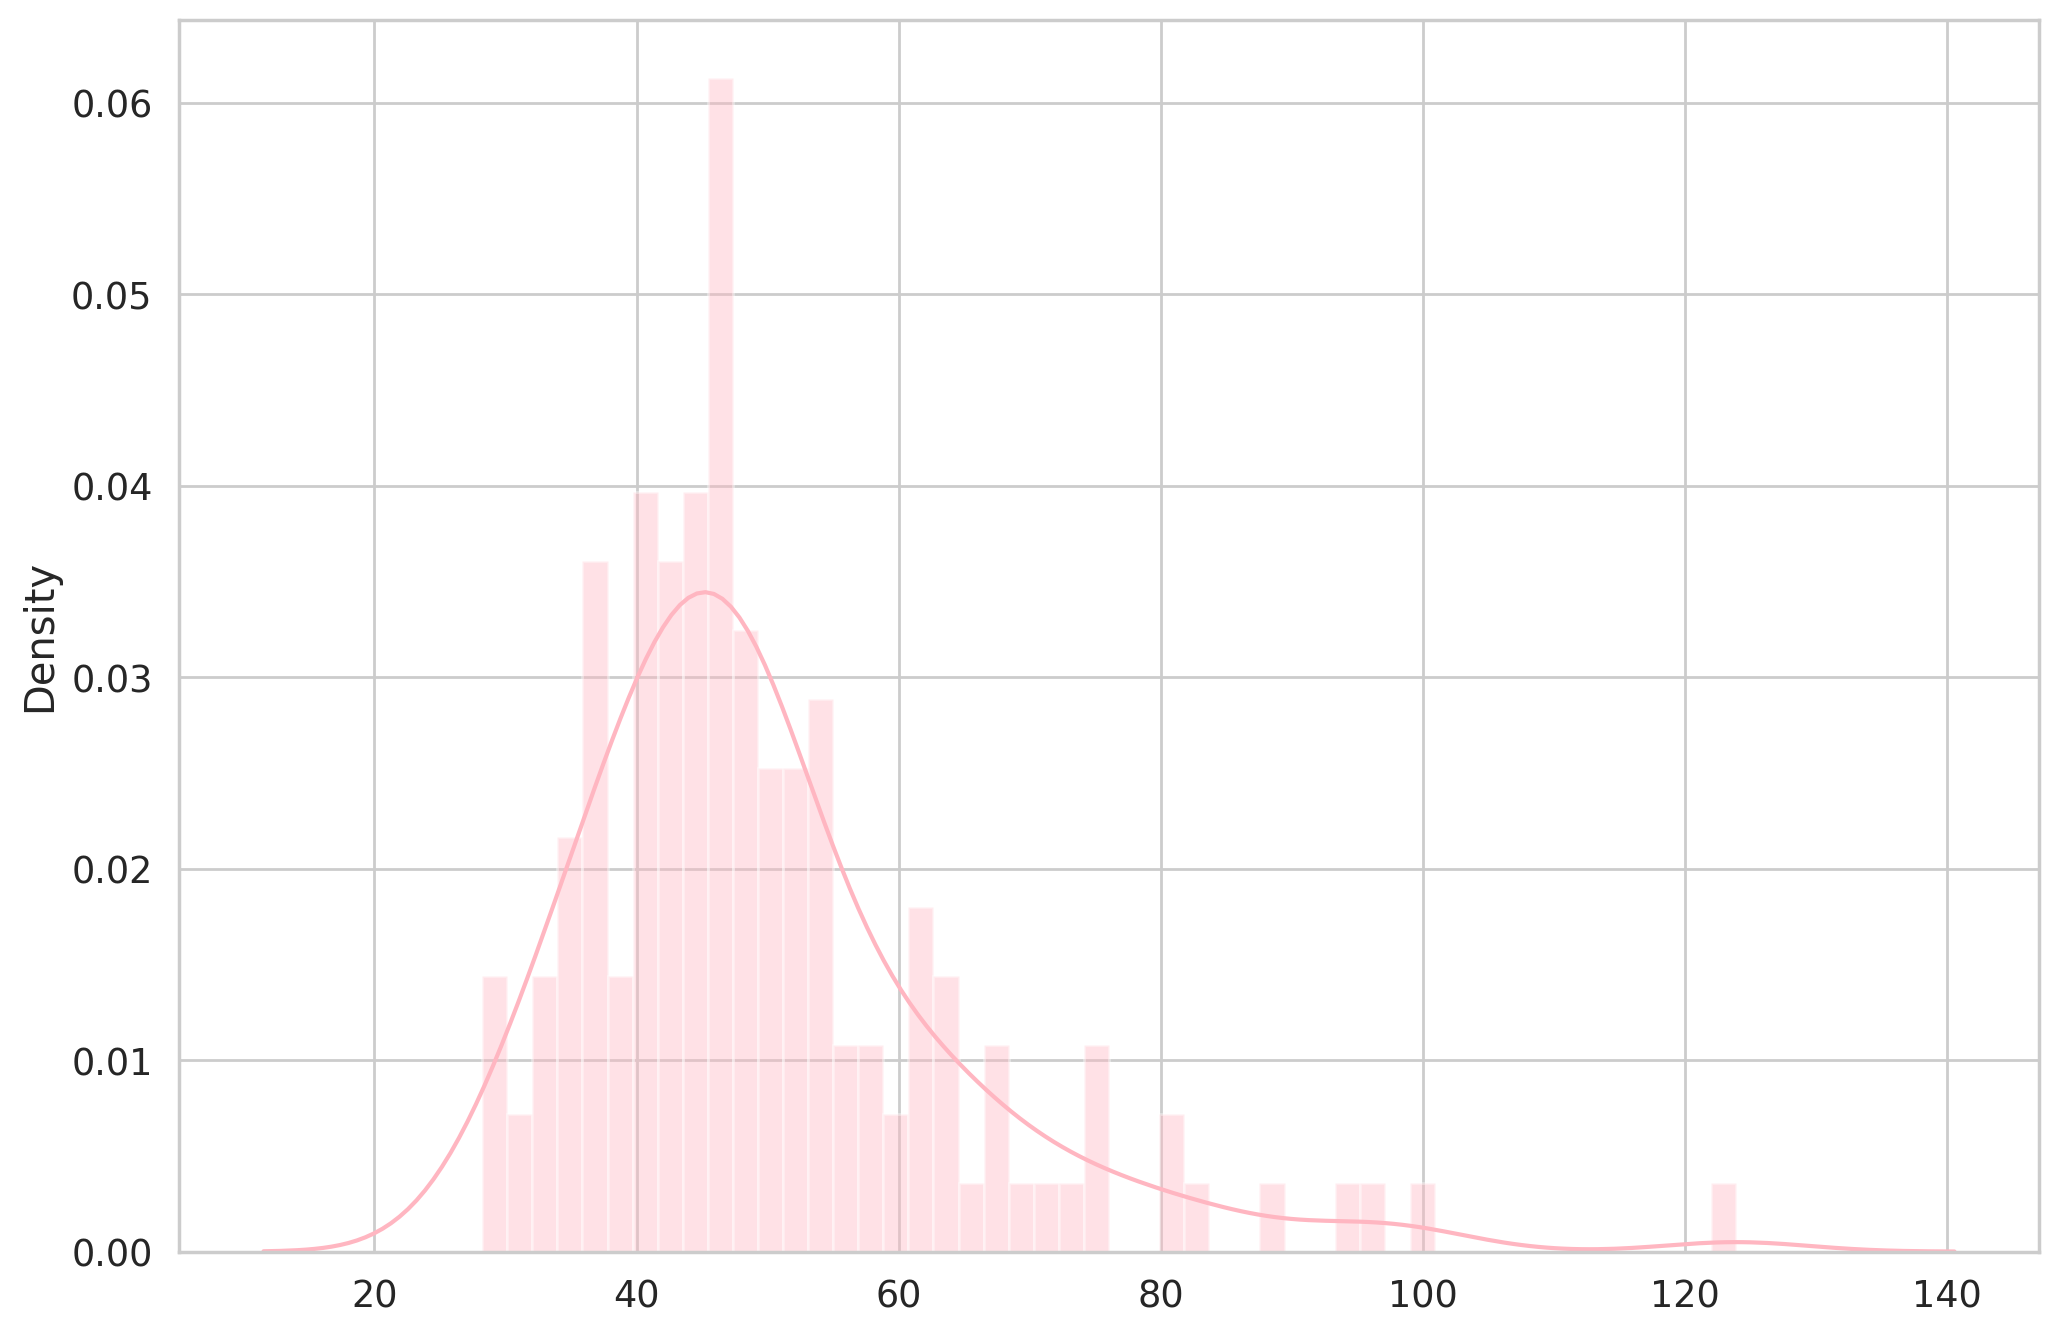

In [109]:
predictions, pred_losses = predict_autoencoder(autoencoder_model, anomaly_sample)
sns.distplot(pred_losses, bins=50, kde=True,color='lightpink')

In [110]:
correct = sum(l > 20 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_sample)}')

Correct anomaly predictions: 145/145


<font color='orange'>Predictions with Hybrid Dataset</font>

In [98]:
# Predict anomalies using Autoencoder model
predictions, losses = predict_autoencoder(autoencoder_model, test_normal_dataset + test_anomaly_dataset)

In [99]:
# Prepare labels for evaluation
y_test = [0] * len(test_normal_dataset) + [1] * len(test_anomaly_dataset)  # 0: normal, 1: anomaly
threshold = np.percentile(losses[:len(test_normal_dataset)], 95)  # Use 95th percentile as threshold for normal data
print("Threshold:", threshold)
y_pred = [1 if loss > threshold else 0 for loss in losses]  # Compare reconstruction loss with threshold

Threshold: 19.21725006103514


In [100]:
# Evaluate the Autoencoder model
print("Autoencoder Classification Report:")
print(classification_report(y_test, y_pred))
autoencoder_auc = roc_auc_score(y_test, losses)
print(f"Autoencoder AUC-ROC: {autoencoder_auc:.4f}")

Autoencoder Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       145
           1       1.00      1.00      1.00      2081

    accuracy                           0.99      2226
   macro avg       0.97      0.97      0.97      2226
weighted avg       0.99      0.99      0.99      2226

Autoencoder AUC-ROC: 0.9981


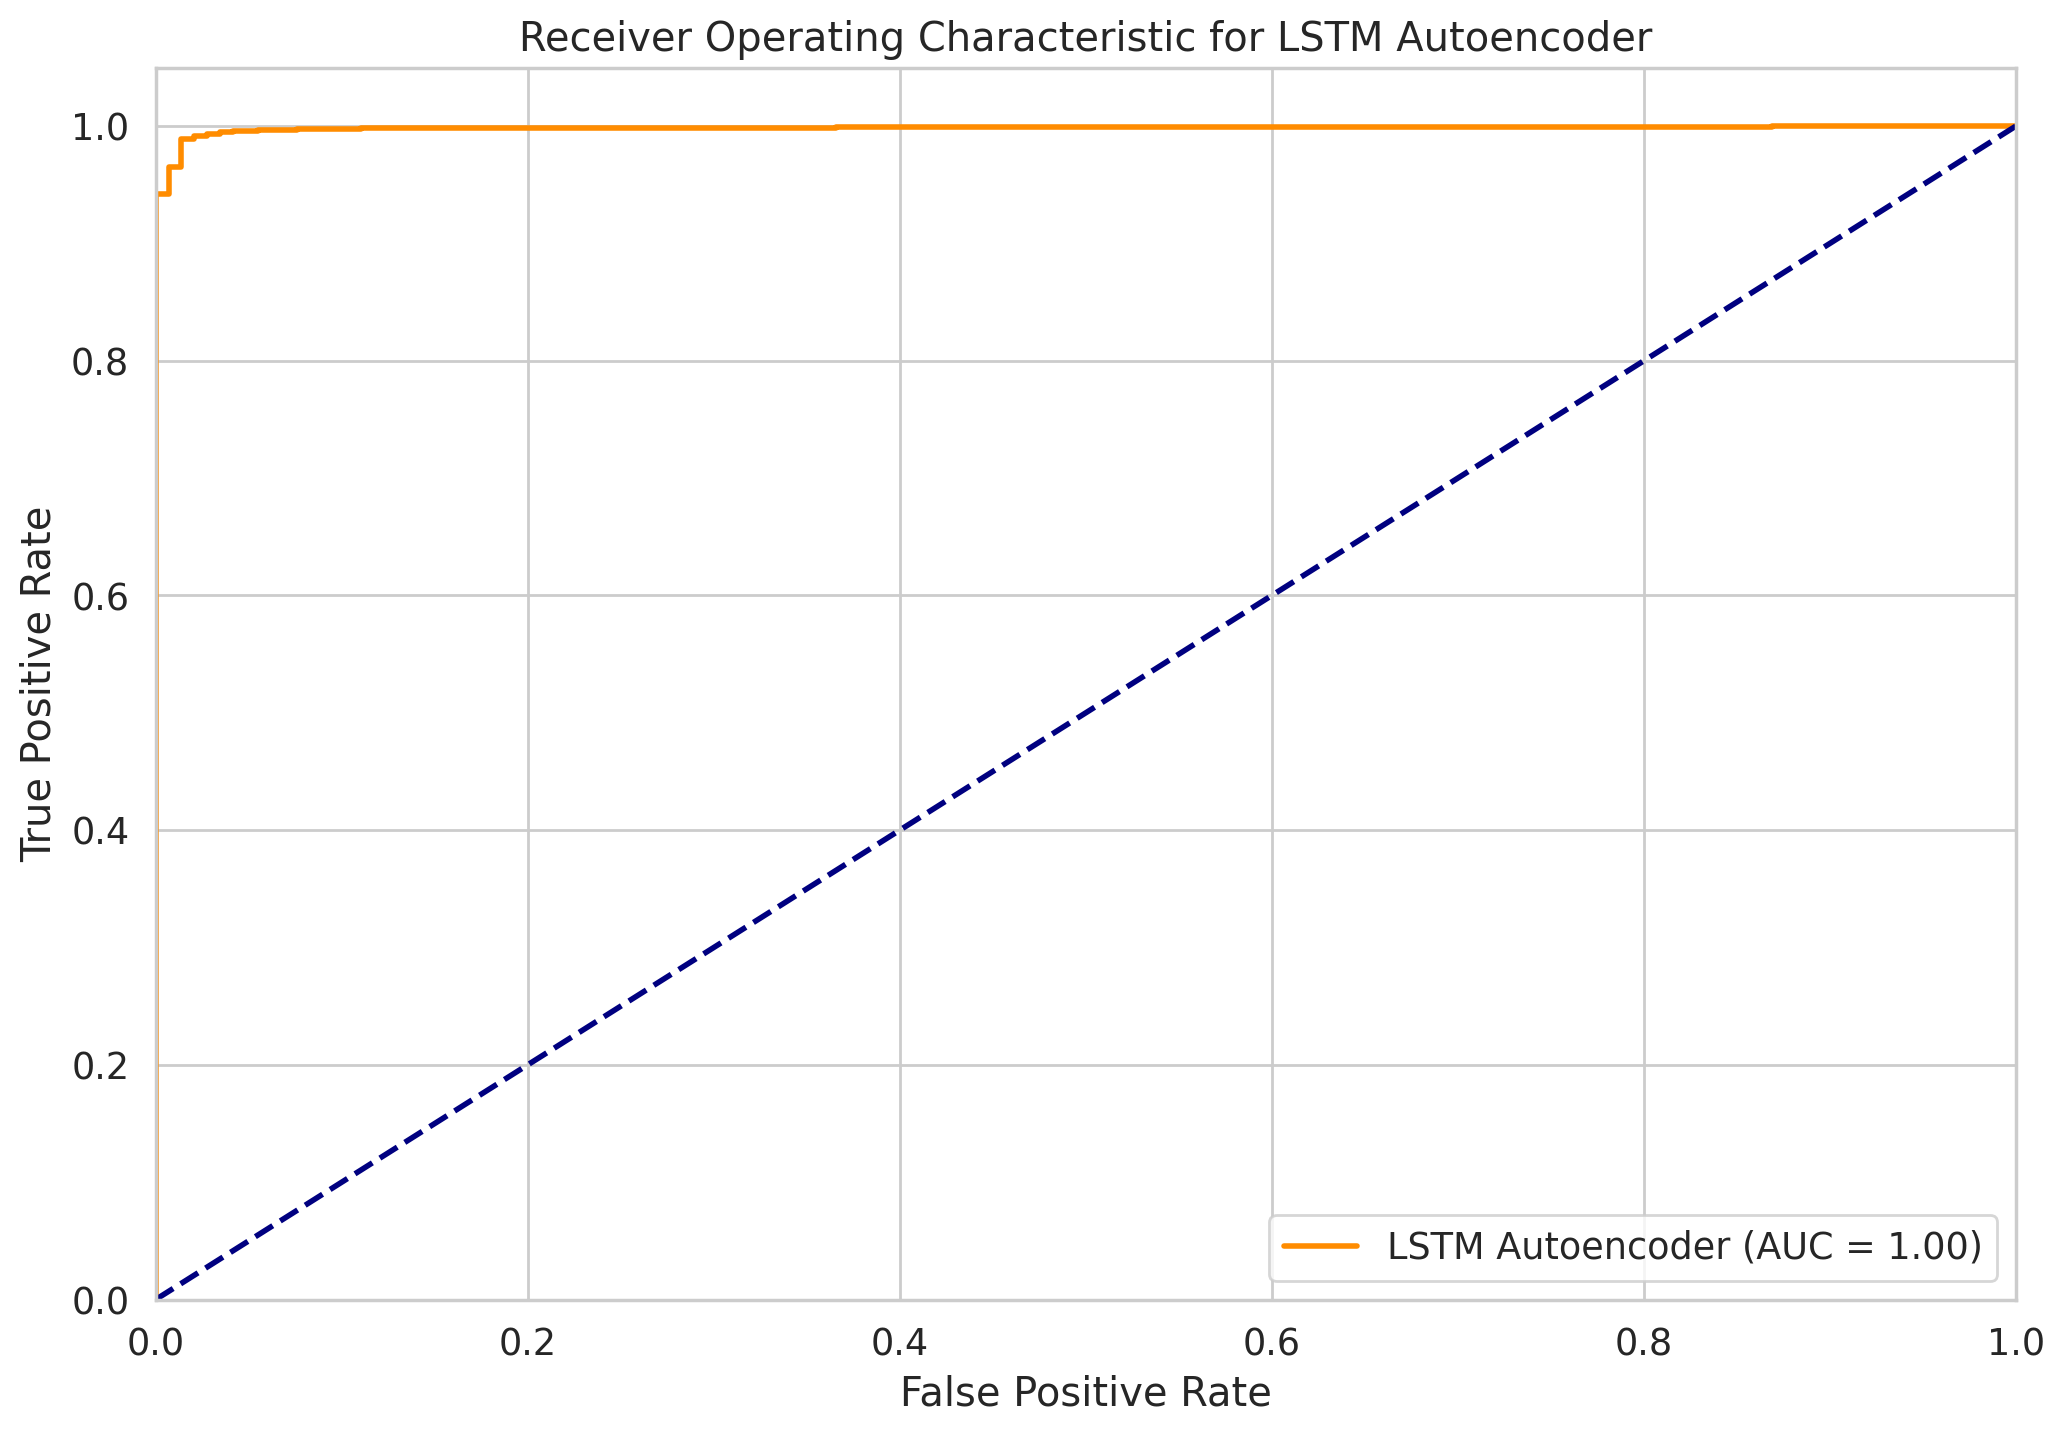

In [46]:
# Calculate ROC curve and AUC for LSTM Autoencoder
fpr_ae, tpr_ae, _ = roc_curve(y_test, losses)
roc_auc_ae = auc(fpr_ae, tpr_ae)

# Plot ROC curve for LSTM Autoencoder
plt.figure()
plt.plot(fpr_ae, tpr_ae, color='darkorange', lw=2, label='LSTM Autoencoder (AUC = %0.2f)' % roc_auc_ae)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LSTM Autoencoder')
plt.legend(loc="lower right")
plt.show()

# 5.0 Plotting Predictions

In [111]:
def plot_ml_prediction(data, model, title, ax, scaler):
    # Reshape and scale the data
    data_scaled = scaler.transform(data.reshape(1, -1))

    # Predict the anomaly score
    if isinstance(model, IsolationForest):
        pred = model.predict(data_scaled)
    elif isinstance(model, OneClassSVM):
        pred = model.predict(data_scaled)
    elif isinstance(model, LocalOutlierFactor):
        pred = model.fit_predict(data_scaled)

    # Plot the results
    ax.plot(data, label='true')
    ax.plot(data, linestyle='None', marker='o', markersize=5, label='pred')
    ax.set_title(f'{title} (score: {np.around(pred[0], 2)})')
    ax.legend()

def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict_autoencoder(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='pred')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

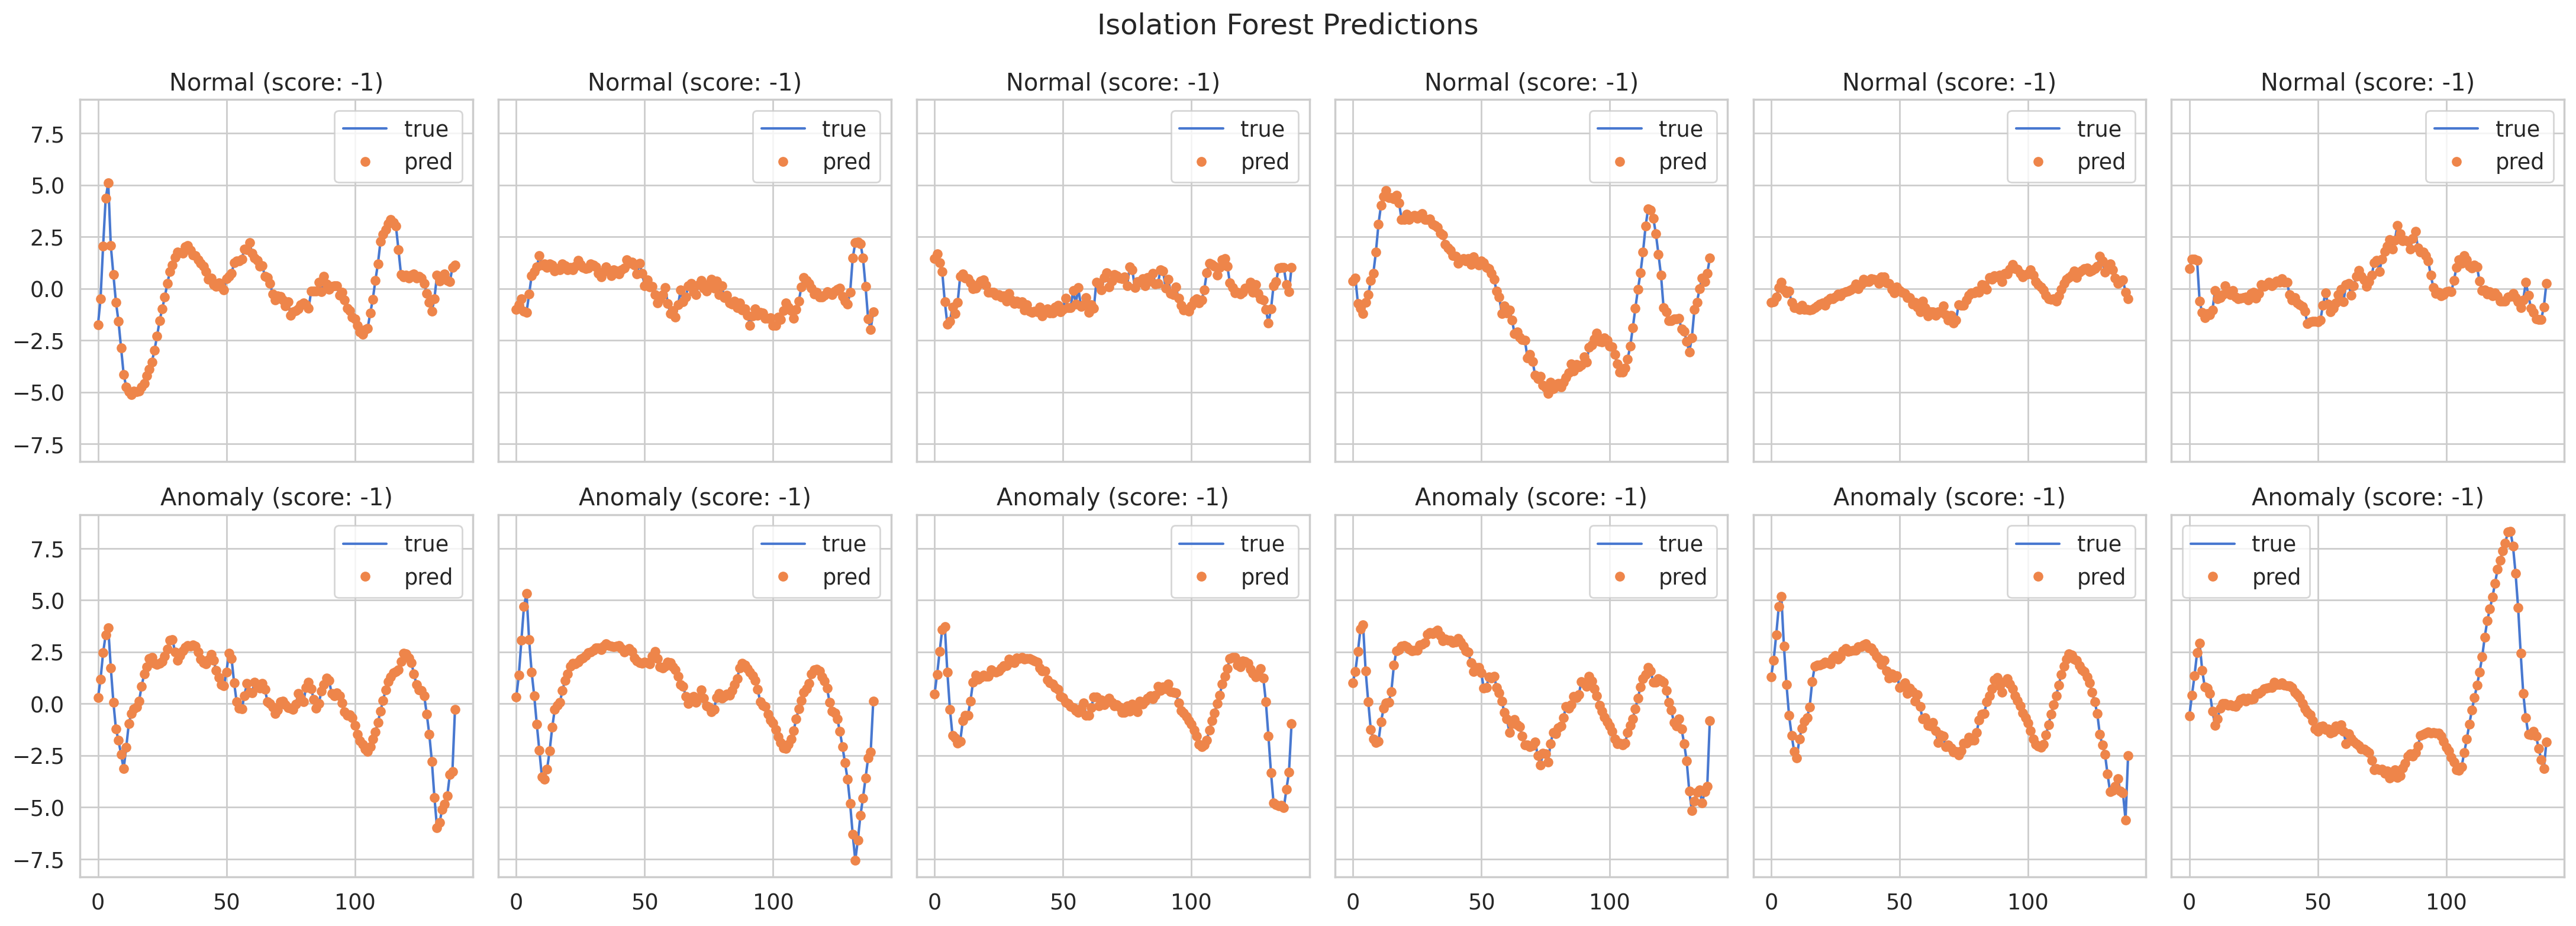

In [75]:
# Prepare a few samples for plotting
normal_samples = test_normal_df_scaled[:6]
anomaly_samples = test_anomaly_df_scaled[:6]

# Plot predictions for Isolation Forest
fig, axs = plt.subplots(nrows=2, ncols=6, sharey=True, sharex=True, figsize=(22, 8))
for i, data in enumerate(normal_samples):
    plot_ml_prediction(data, iso_forest, title='Normal', ax=axs[0, i], scaler=scaler)
for i, data in enumerate(anomaly_samples):
    plot_ml_prediction(data, iso_forest, title='Anomaly', ax=axs[1, i], scaler=scaler)
fig.suptitle("Isolation Forest Predictions")
fig.tight_layout()
plt.show()

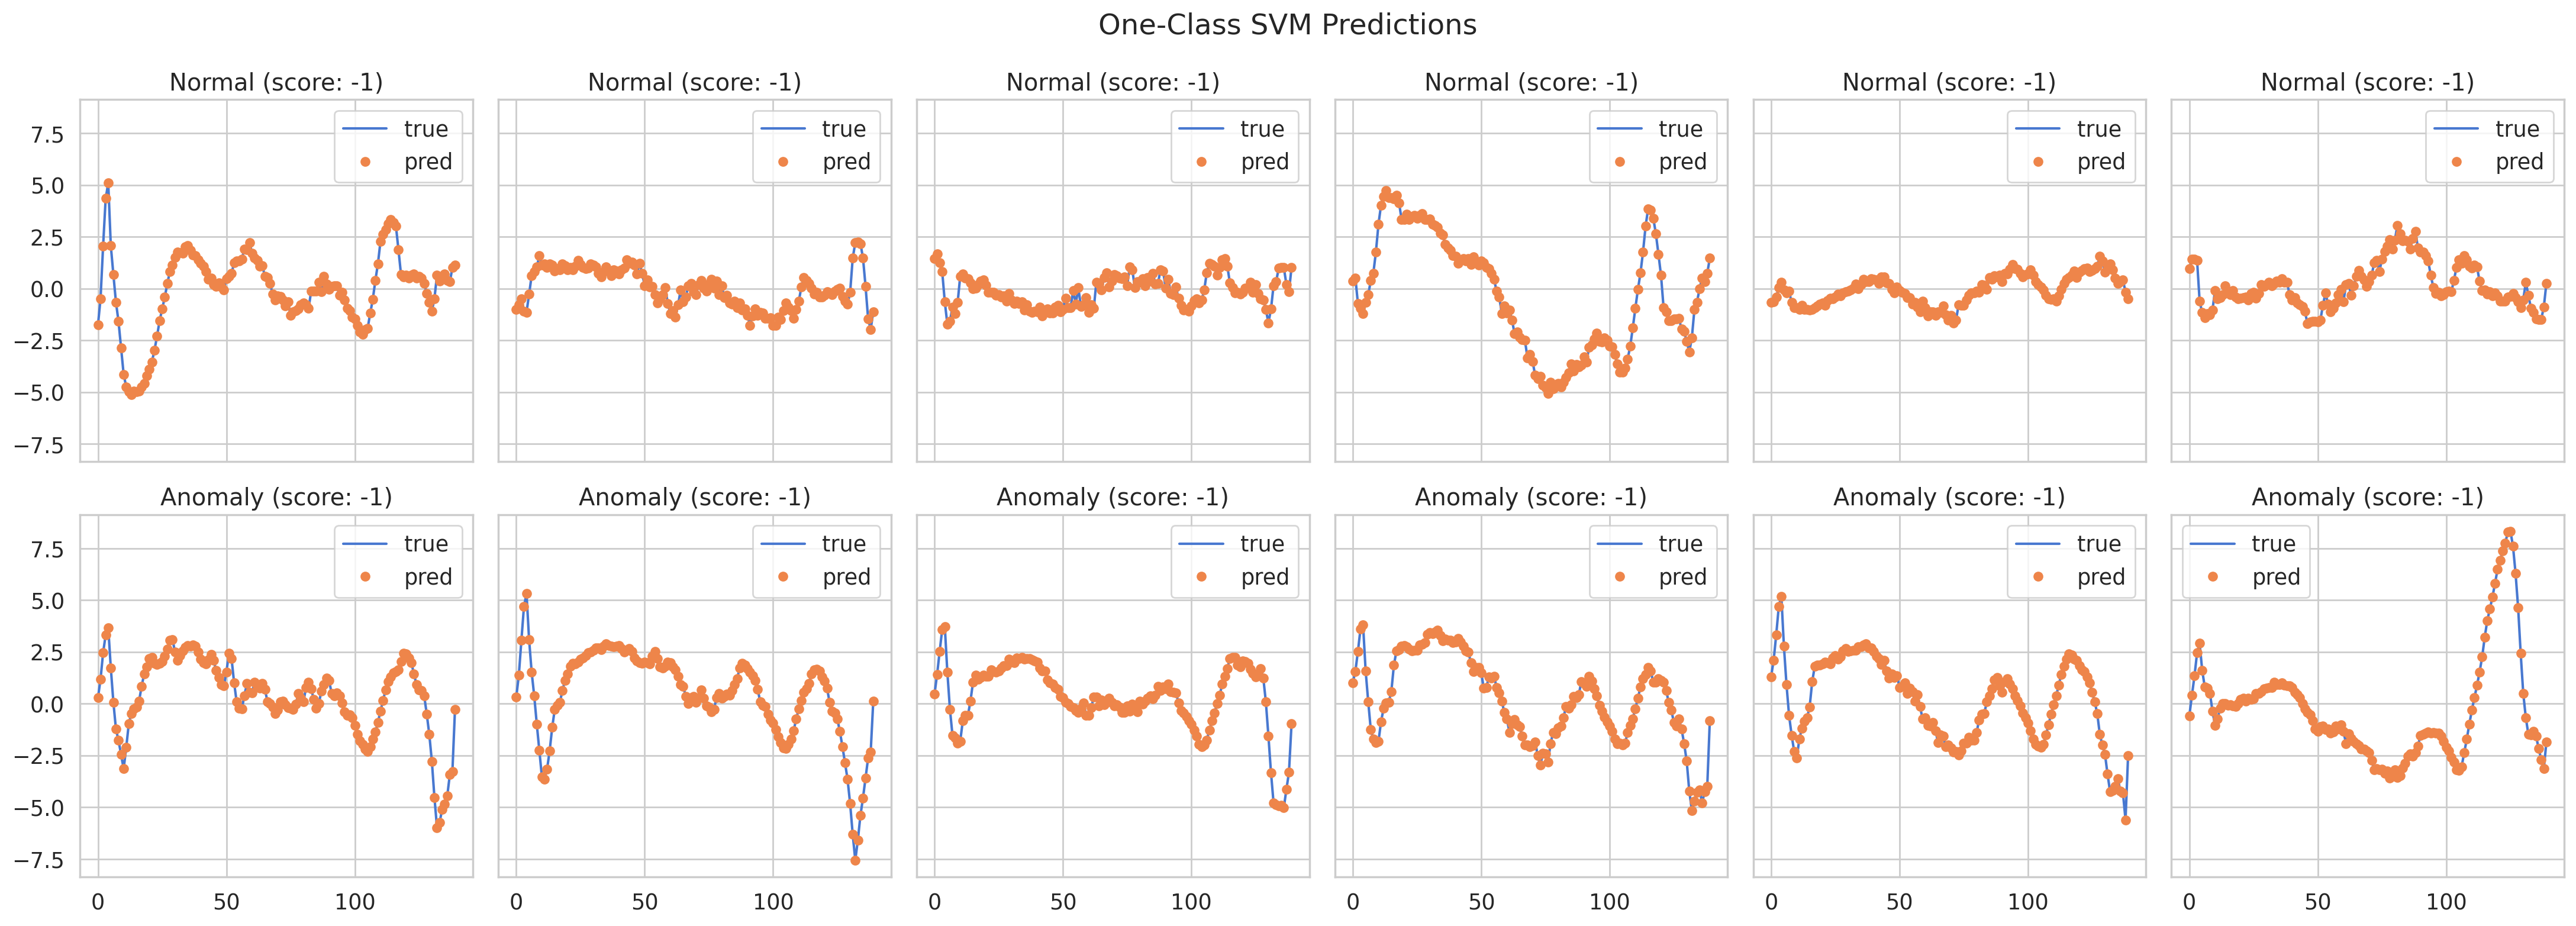

In [76]:
# Plot predictions for One-Class SVM
fig, axs = plt.subplots(nrows=2, ncols=6, sharey=True, sharex=True, figsize=(22, 8))
for i, data in enumerate(normal_samples):
    plot_ml_prediction(data, oc_svm, title='Normal', ax=axs[0, i], scaler=scaler)
for i, data in enumerate(anomaly_samples):
    plot_ml_prediction(data, oc_svm, title='Anomaly', ax=axs[1, i], scaler=scaler)
fig.suptitle("One-Class SVM Predictions")
fig.tight_layout()
plt.show()

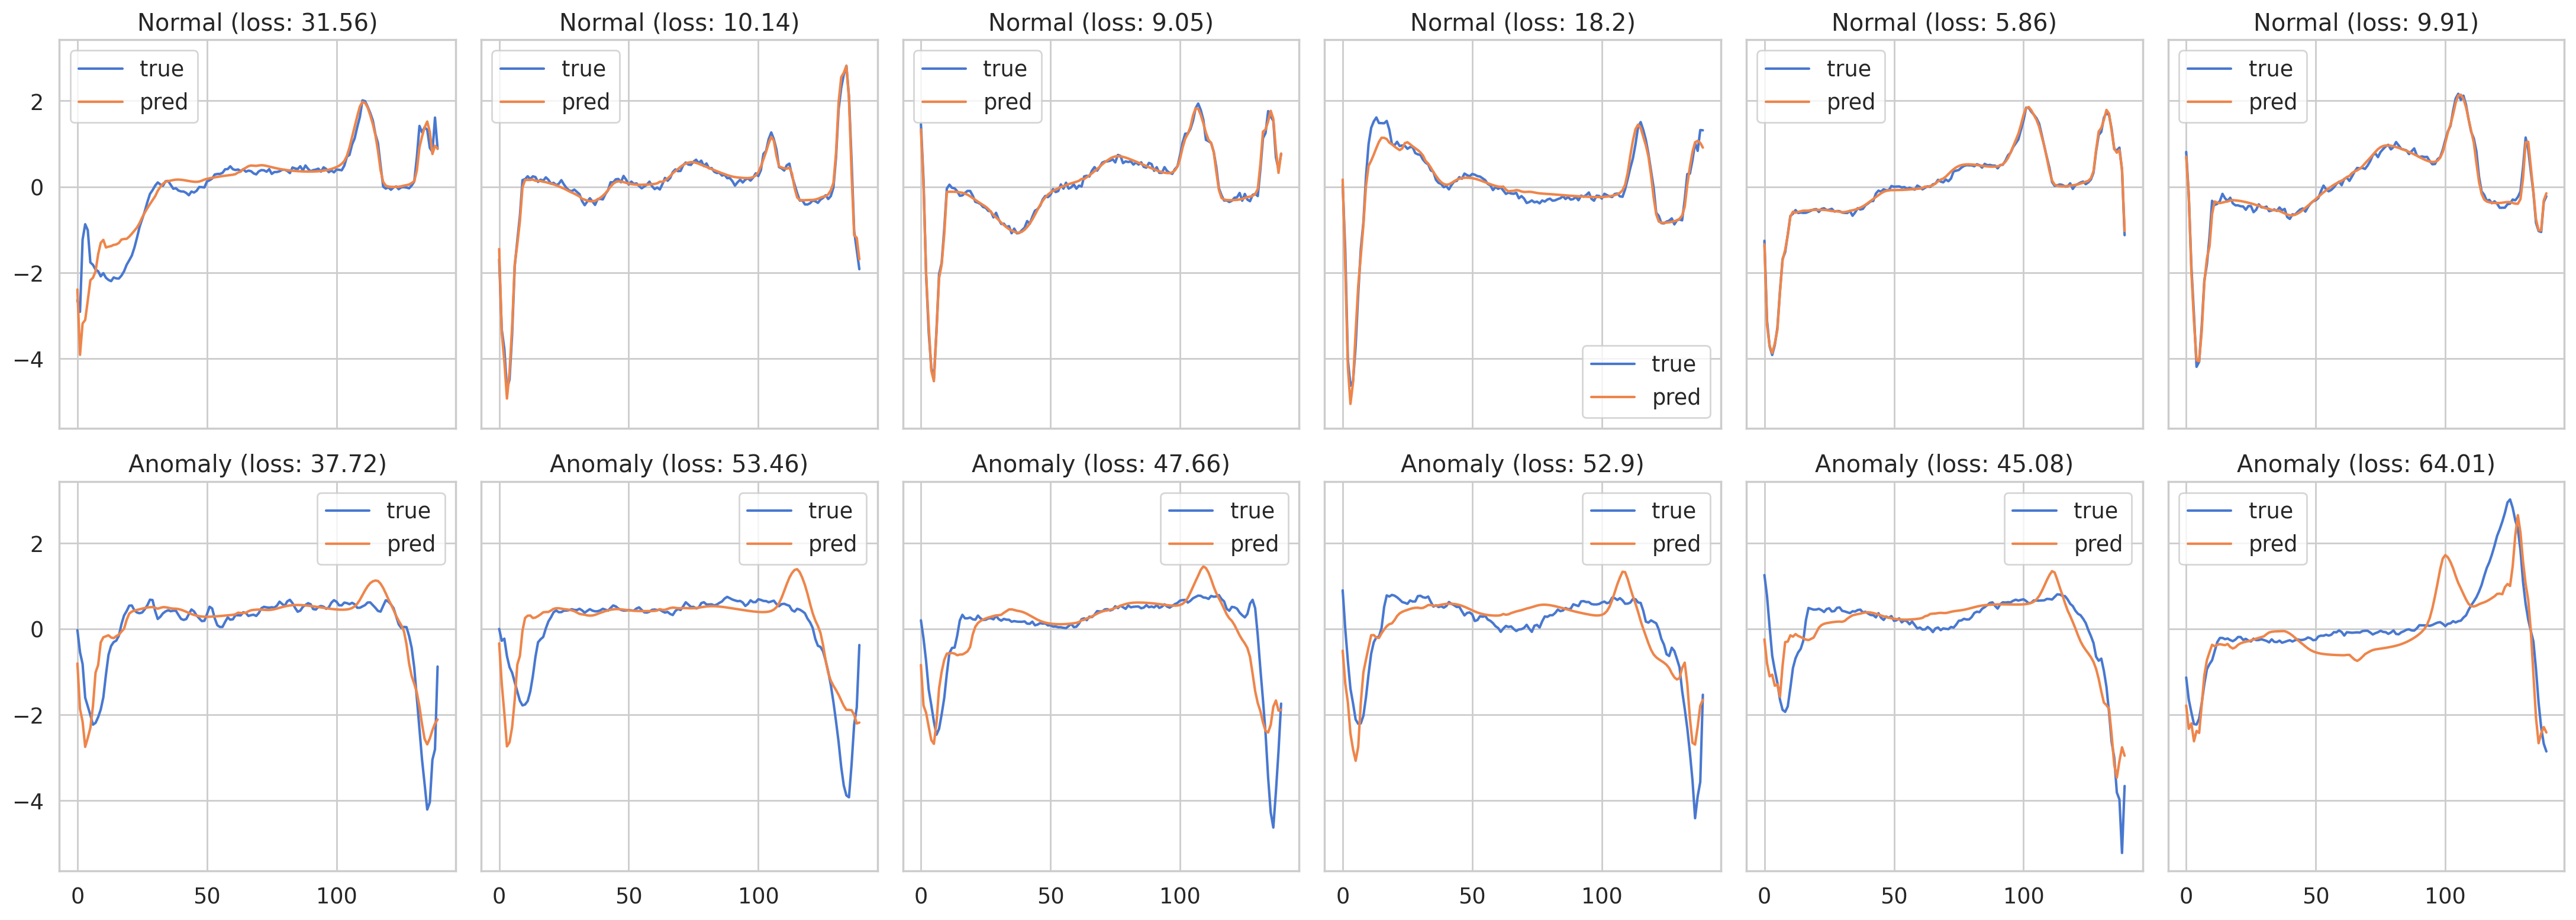

In [112]:
# Plot predictions for LSTM Autoencoder
fig, axs = plt.subplots(nrows=2, ncols=6, sharey=True, sharex=True, figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, autoencoder_model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, autoencoder_model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()
plt.show()